In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(1, 9)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 100
WINDOW_SIZE = 200
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [8]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return np.array(balance_x), np.array(balance_y)

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
prediction_total = []
test_data_total = []

models = []
for i in range(N_LABELS):
    models.append(init_cnn(WINDOW_SIZE))

for subject in TRAIN_SUBJECTS:
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]
    x_train, _, y_train, _ = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.001)

    
    for i in range(N_LABELS):
        model = models[i]
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))
        
        x = [balanced_x_train[j::2] for j in range(2)]
        y = [train_labels[j::2] for j in range(2)]
        result = np.array([])
        for sample_x, sample_y in zip(x, y):
            model.fit(np.array(sample_x), np.array(sample_y), verbose=1, validation_split=0.2, epochs=EPOCHS)
        
        
        
#         model.fit(balanced_x_train, train_labels, verbose=1, validation_split=0.2, epochs=EPOCHS)
    
    
    for task_name, model in zip(COLUMNS, models):
        model.save('general_model_'+task_name+'_subject_%d.h5' % (subject))  # creates a HDF5 file 'my_model.h5'
#         predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
#         test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
#         prediction_total.append(predictions)
        
#     multiple_metric_auc_score(prediction_total, test_data_total, True)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train subject 1, class HandStart
Train on 3116 samples, validate on 780 samples
Epoch 1/100
3116/3116 [==============================] - 4s 1ms/step - loss: 0.7040 - acc: 0.4901 - val_loss: 0.6976 - val_acc: 0.4821
Epoch 2/100
3116/3116 [==============================] - 1s 331us/step - loss: 0.6965 - acc: 0.4987 - val_loss: 0.6941 - val_acc: 0.5000
Epoch 3/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.6953 - acc: 0.5064 - val_loss: 0.6928 - val_acc: 0.5154
Epoch 4/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.6933 - acc: 0.5215 - val_loss: 0.6919 - val_acc: 0.5167
Epoch 5/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.6919 - acc: 0.5167 - val_loss: 0.6912 - val_acc: 0.5179
Epoch 6/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.6926 - acc: 0.5186 - val_loss: 0.6907 - val_acc: 0.5167
Epoch 7/100
3116/

3116/3116 [==============================] - 1s 332us/step - loss: 0.6123 - acc: 0.6942 - val_loss: 0.5956 - val_acc: 0.7077
Epoch 58/100
3116/3116 [==============================] - 1s 338us/step - loss: 0.6089 - acc: 0.6842 - val_loss: 0.5926 - val_acc: 0.7077
Epoch 59/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.6011 - acc: 0.6935 - val_loss: 0.5893 - val_acc: 0.7064
Epoch 60/100
3116/3116 [==============================] - 1s 337us/step - loss: 0.6016 - acc: 0.6849 - val_loss: 0.5864 - val_acc: 0.7038
Epoch 61/100
3116/3116 [==============================] - 1s 361us/step - loss: 0.5940 - acc: 0.6983 - val_loss: 0.5837 - val_acc: 0.7064
Epoch 62/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.5873 - acc: 0.7115 - val_loss: 0.5809 - val_acc: 0.7077
Epoch 63/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.5875 - acc: 0.7022 - val_loss: 0.5789 - val_acc: 0.7064
Epoch 64/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 338us/step - loss: 0.5315 - acc: 0.7452 - val_loss: 0.5389 - val_acc: 0.7436
Epoch 17/100
3116/3116 [==============================] - 1s 337us/step - loss: 0.5365 - acc: 0.7359 - val_loss: 0.5381 - val_acc: 0.7462
Epoch 18/100
3116/3116 [==============================] - 1s 336us/step - loss: 0.5364 - acc: 0.7368 - val_loss: 0.5373 - val_acc: 0.7500
Epoch 19/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.5305 - acc: 0.7401 - val_loss: 0.5368 - val_acc: 0.7500
Epoch 20/100
3116/3116 [==============================] - 1s 336us/step - loss: 0.5407 - acc: 0.7375 - val_loss: 0.5360 - val_acc: 0.7500
Epoch 21/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.5287 - acc: 0.7471 - val_loss: 0.5354 - val_acc: 0.7526
Epoch 22/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.5349 - acc: 0.7420 - val_loss: 0.5350 - val_acc: 0.7551
Epoch 23/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 328us/step - loss: 0.4922 - acc: 0.7654 - val_loss: 0.4902 - val_acc: 0.7679
Epoch 76/100
3116/3116 [==============================] - 1s 326us/step - loss: 0.4847 - acc: 0.7693 - val_loss: 0.4890 - val_acc: 0.7744
Epoch 77/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.4885 - acc: 0.7670 - val_loss: 0.4867 - val_acc: 0.7705
Epoch 78/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.4820 - acc: 0.7737 - val_loss: 0.4857 - val_acc: 0.7756
Epoch 79/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.4821 - acc: 0.7734 - val_loss: 0.4850 - val_acc: 0.7731
Epoch 80/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.4813 - acc: 0.7811 - val_loss: 0.4837 - val_acc: 0.7744
Epoch 81/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.4839 - acc: 0.7750 - val_loss: 0.4831 - val_acc: 0.7705
Epoch 82/100
3116/3116 [=======================

Epoch 34/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.5922 - acc: 0.7583 - val_loss: 0.5679 - val_acc: 0.8383
Epoch 35/100
3116/3116 [==============================] - 1s 327us/step - loss: 0.5823 - acc: 0.7638 - val_loss: 0.5560 - val_acc: 0.8434
Epoch 36/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.5770 - acc: 0.7606 - val_loss: 0.5437 - val_acc: 0.8434
Epoch 37/100
3116/3116 [==============================] - 1s 331us/step - loss: 0.5625 - acc: 0.7744 - val_loss: 0.5311 - val_acc: 0.8447
Epoch 38/100
3116/3116 [==============================] - 1s 331us/step - loss: 0.5495 - acc: 0.7834 - val_loss: 0.5195 - val_acc: 0.8357
Epoch 39/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.5350 - acc: 0.7869 - val_loss: 0.5036 - val_acc: 0.8460
Epoch 40/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.5244 - acc: 0.7943 - val_loss: 0.4887 - val_acc: 0.8537
Epoch 41/100
3116/3116 [==========

3116/3116 [==============================] - 1s 329us/step - loss: 0.2607 - acc: 0.8902 - val_loss: 0.2772 - val_acc: 0.8999
Epoch 94/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.2584 - acc: 0.8967 - val_loss: 0.2803 - val_acc: 0.8986
Epoch 95/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.2495 - acc: 0.8979 - val_loss: 0.2740 - val_acc: 0.8999
Epoch 96/100
3116/3116 [==============================] - 1s 380us/step - loss: 0.2492 - acc: 0.8986 - val_loss: 0.2696 - val_acc: 0.9037
Epoch 97/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.2454 - acc: 0.9005 - val_loss: 0.2713 - val_acc: 0.9012
Epoch 98/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.2499 - acc: 0.8999 - val_loss: 0.2657 - val_acc: 0.9012
Epoch 99/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.2543 - acc: 0.8967 - val_loss: 0.2719 - val_acc: 0.8986
Epoch 100/100
3116/3116 [======================

3116/3116 [==============================] - 1s 343us/step - loss: 0.1969 - acc: 0.9272 - val_loss: 0.1634 - val_acc: 0.9409
Epoch 53/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.1952 - acc: 0.9278 - val_loss: 0.1638 - val_acc: 0.9409
Epoch 54/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.1957 - acc: 0.9278 - val_loss: 0.1691 - val_acc: 0.9384
Epoch 55/100
3116/3116 [==============================] - 1s 338us/step - loss: 0.1900 - acc: 0.9300 - val_loss: 0.1675 - val_acc: 0.9384
Epoch 56/100
3116/3116 [==============================] - 1s 331us/step - loss: 0.1943 - acc: 0.9291 - val_loss: 0.1572 - val_acc: 0.9435
Epoch 57/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.1893 - acc: 0.9358 - val_loss: 0.1594 - val_acc: 0.9435
Epoch 58/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.1933 - acc: 0.9316 - val_loss: 0.1616 - val_acc: 0.9435
Epoch 59/100
3116/3116 [=======================

Epoch 11/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.6871 - acc: 0.5419 - val_loss: 0.6815 - val_acc: 0.6487
Epoch 12/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.6862 - acc: 0.5512 - val_loss: 0.6804 - val_acc: 0.6564
Epoch 13/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.6849 - acc: 0.5544 - val_loss: 0.6794 - val_acc: 0.6577
Epoch 14/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.6849 - acc: 0.5525 - val_loss: 0.6781 - val_acc: 0.6577
Epoch 15/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.6841 - acc: 0.5598 - val_loss: 0.6768 - val_acc: 0.6641
Epoch 16/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.6844 - acc: 0.5541 - val_loss: 0.6757 - val_acc: 0.6654
Epoch 17/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.6843 - acc: 0.5621 - val_loss: 0.6743 - val_acc: 0.6731
Epoch 18/100
3117/3117 [==========

3117/3117 [==============================] - 1s 333us/step - loss: 0.3941 - acc: 0.8338 - val_loss: 0.3398 - val_acc: 0.8538
Epoch 71/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.3919 - acc: 0.8386 - val_loss: 0.3335 - val_acc: 0.8526
Epoch 72/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.3787 - acc: 0.8409 - val_loss: 0.3278 - val_acc: 0.8590
Epoch 73/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.3801 - acc: 0.8422 - val_loss: 0.3194 - val_acc: 0.8628
Epoch 74/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.3743 - acc: 0.8412 - val_loss: 0.3176 - val_acc: 0.8667
Epoch 75/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.3705 - acc: 0.8495 - val_loss: 0.3091 - val_acc: 0.8679
Epoch 76/100
3117/3117 [==============================] - 1s 334us/step - loss: 0.3627 - acc: 0.8508 - val_loss: 0.3036 - val_acc: 0.8692
Epoch 77/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 334us/step - loss: 0.2497 - acc: 0.8983 - val_loss: 0.2251 - val_acc: 0.9154
Epoch 30/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.2448 - acc: 0.9009 - val_loss: 0.2294 - val_acc: 0.9218
Epoch 31/100
3117/3117 [==============================] - 1s 328us/step - loss: 0.2394 - acc: 0.9021 - val_loss: 0.2224 - val_acc: 0.9128
Epoch 32/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.2447 - acc: 0.9050 - val_loss: 0.2220 - val_acc: 0.9179
Epoch 33/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.2407 - acc: 0.9076 - val_loss: 0.2225 - val_acc: 0.9244
Epoch 34/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.2359 - acc: 0.9121 - val_loss: 0.2205 - val_acc: 0.9231
Epoch 35/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.2340 - acc: 0.9057 - val_loss: 0.2174 - val_acc: 0.9192
Epoch 36/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 330us/step - loss: 0.1822 - acc: 0.9297 - val_loss: 0.1750 - val_acc: 0.9385
Epoch 89/100
3117/3117 [==============================] - 1s 330us/step - loss: 0.1890 - acc: 0.9307 - val_loss: 0.1804 - val_acc: 0.9397
Epoch 90/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.1841 - acc: 0.9329 - val_loss: 0.1819 - val_acc: 0.9410
Epoch 91/100
3117/3117 [==============================] - 1s 325us/step - loss: 0.1739 - acc: 0.9400 - val_loss: 0.1769 - val_acc: 0.9410
Epoch 92/100
3117/3117 [==============================] - 1s 328us/step - loss: 0.1649 - acc: 0.9432 - val_loss: 0.1802 - val_acc: 0.9410
Epoch 93/100
3117/3117 [==============================] - 1s 330us/step - loss: 0.1863 - acc: 0.9317 - val_loss: 0.1773 - val_acc: 0.9397
Epoch 94/100
3117/3117 [==============================] - 1s 327us/step - loss: 0.1835 - acc: 0.9323 - val_loss: 0.1745 - val_acc: 0.9423
Epoch 95/100
3117/3117 [=======================

Epoch 47/100
3119/3119 [==============================] - 1s 332us/step - loss: 0.6174 - acc: 0.7095 - val_loss: 0.5964 - val_acc: 0.7590
Epoch 48/100
3119/3119 [==============================] - 1s 333us/step - loss: 0.6069 - acc: 0.7195 - val_loss: 0.5872 - val_acc: 0.7577
Epoch 49/100
3119/3119 [==============================] - 1s 331us/step - loss: 0.6008 - acc: 0.7130 - val_loss: 0.5777 - val_acc: 0.7590
Epoch 50/100
3119/3119 [==============================] - 1s 331us/step - loss: 0.5963 - acc: 0.7175 - val_loss: 0.5676 - val_acc: 0.7564
Epoch 51/100
3119/3119 [==============================] - 1s 324us/step - loss: 0.5859 - acc: 0.7288 - val_loss: 0.5574 - val_acc: 0.7590
Epoch 52/100
3119/3119 [==============================] - 1s 330us/step - loss: 0.5772 - acc: 0.7249 - val_loss: 0.5472 - val_acc: 0.7731
Epoch 53/100
3119/3119 [==============================] - 1s 333us/step - loss: 0.5625 - acc: 0.7390 - val_loss: 0.5359 - val_acc: 0.7718
Epoch 54/100
3119/3119 [==========

3119/3119 [==============================] - 1s 335us/step - loss: 0.3243 - acc: 0.8772 - val_loss: 0.2936 - val_acc: 0.8923
Epoch 7/100
3119/3119 [==============================] - 1s 336us/step - loss: 0.3266 - acc: 0.8711 - val_loss: 0.2938 - val_acc: 0.8949
Epoch 8/100
3119/3119 [==============================] - 1s 330us/step - loss: 0.3281 - acc: 0.8711 - val_loss: 0.2894 - val_acc: 0.8885
Epoch 9/100
3119/3119 [==============================] - 1s 329us/step - loss: 0.3221 - acc: 0.8730 - val_loss: 0.2862 - val_acc: 0.8949
Epoch 10/100
3119/3119 [==============================] - 1s 330us/step - loss: 0.3132 - acc: 0.8778 - val_loss: 0.2834 - val_acc: 0.8936
Epoch 11/100
3119/3119 [==============================] - 1s 334us/step - loss: 0.3156 - acc: 0.8788 - val_loss: 0.2810 - val_acc: 0.8936
Epoch 12/100
3119/3119 [==============================] - 1s 333us/step - loss: 0.3132 - acc: 0.8814 - val_loss: 0.2785 - val_acc: 0.8949
Epoch 13/100
3119/3119 [==========================

3119/3119 [==============================] - 1s 329us/step - loss: 0.2264 - acc: 0.9176 - val_loss: 0.2028 - val_acc: 0.9346
Epoch 66/100
3119/3119 [==============================] - 1s 329us/step - loss: 0.2241 - acc: 0.9218 - val_loss: 0.2030 - val_acc: 0.9346
Epoch 67/100
3119/3119 [==============================] - 1s 329us/step - loss: 0.2261 - acc: 0.9176 - val_loss: 0.2035 - val_acc: 0.9346
Epoch 68/100
3119/3119 [==============================] - 1s 332us/step - loss: 0.2282 - acc: 0.9170 - val_loss: 0.2031 - val_acc: 0.9346
Epoch 69/100
3119/3119 [==============================] - 1s 328us/step - loss: 0.2255 - acc: 0.9189 - val_loss: 0.2031 - val_acc: 0.9359
Epoch 70/100
3119/3119 [==============================] - 1s 328us/step - loss: 0.2241 - acc: 0.9179 - val_loss: 0.2017 - val_acc: 0.9359
Epoch 71/100
3119/3119 [==============================] - 1s 326us/step - loss: 0.2258 - acc: 0.9147 - val_loss: 0.2020 - val_acc: 0.9346
Epoch 72/100
3119/3119 [=======================

3114/3114 [==============================] - 1s 328us/step - loss: 0.6794 - acc: 0.6044 - val_loss: 0.6729 - val_acc: 0.7356
Epoch 24/100
3114/3114 [==============================] - 1s 326us/step - loss: 0.6798 - acc: 0.5925 - val_loss: 0.6713 - val_acc: 0.7343
Epoch 25/100
3114/3114 [==============================] - 1s 333us/step - loss: 0.6774 - acc: 0.6098 - val_loss: 0.6695 - val_acc: 0.7368
Epoch 26/100
3114/3114 [==============================] - 1s 330us/step - loss: 0.6765 - acc: 0.6130 - val_loss: 0.6674 - val_acc: 0.7394
Epoch 27/100
3114/3114 [==============================] - 1s 328us/step - loss: 0.6730 - acc: 0.6162 - val_loss: 0.6651 - val_acc: 0.7394
Epoch 28/100
3114/3114 [==============================] - 1s 327us/step - loss: 0.6700 - acc: 0.6374 - val_loss: 0.6624 - val_acc: 0.7420
Epoch 29/100
3114/3114 [==============================] - 1s 334us/step - loss: 0.6687 - acc: 0.6313 - val_loss: 0.6595 - val_acc: 0.7445
Epoch 30/100
3114/3114 [=======================

3114/3114 [==============================] - 1s 341us/step - loss: 0.2719 - acc: 0.8966 - val_loss: 0.2526 - val_acc: 0.9076
Epoch 83/100
3114/3114 [==============================] - 1s 349us/step - loss: 0.2672 - acc: 0.9024 - val_loss: 0.2458 - val_acc: 0.9127
Epoch 84/100
3114/3114 [==============================] - 1s 337us/step - loss: 0.2681 - acc: 0.8969 - val_loss: 0.2456 - val_acc: 0.9089
Epoch 85/100
3114/3114 [==============================] - 1s 384us/step - loss: 0.2672 - acc: 0.9014 - val_loss: 0.2446 - val_acc: 0.9114
Epoch 86/100
3114/3114 [==============================] - 1s 377us/step - loss: 0.2641 - acc: 0.9024 - val_loss: 0.2421 - val_acc: 0.9089
Epoch 87/100
3114/3114 [==============================] - 1s 363us/step - loss: 0.2543 - acc: 0.9101 - val_loss: 0.2453 - val_acc: 0.9101
Epoch 88/100
3114/3114 [==============================] - 1s 360us/step - loss: 0.2549 - acc: 0.9114 - val_loss: 0.2371 - val_acc: 0.9140
Epoch 89/100
3114/3114 [=======================

3114/3114 [==============================] - 1s 353us/step - loss: 0.1609 - acc: 0.9425 - val_loss: 0.1525 - val_acc: 0.9538
Epoch 42/100
3114/3114 [==============================] - 1s 341us/step - loss: 0.1741 - acc: 0.9419 - val_loss: 0.1538 - val_acc: 0.9551
Epoch 43/100
3114/3114 [==============================] - 1s 339us/step - loss: 0.1645 - acc: 0.9441 - val_loss: 0.1522 - val_acc: 0.9589
Epoch 44/100
3114/3114 [==============================] - 1s 336us/step - loss: 0.1594 - acc: 0.9477 - val_loss: 0.1498 - val_acc: 0.9551
Epoch 45/100
3114/3114 [==============================] - 1s 345us/step - loss: 0.1672 - acc: 0.9387 - val_loss: 0.1491 - val_acc: 0.9538
Epoch 46/100
3114/3114 [==============================] - 1s 342us/step - loss: 0.1678 - acc: 0.9422 - val_loss: 0.1497 - val_acc: 0.9602
Epoch 47/100
3114/3114 [==============================] - 1s 340us/step - loss: 0.1634 - acc: 0.9454 - val_loss: 0.1491 - val_acc: 0.9576
Epoch 48/100
3114/3114 [=======================

3114/3114 [==============================] - 1s 354us/step - loss: 0.1357 - acc: 0.9563 - val_loss: 0.1313 - val_acc: 0.9653
Train subject 1, class BothReleased
Train on 3115 samples, validate on 779 samples
Epoch 1/100
3115/3115 [==============================] - 2s 542us/step - loss: 0.6934 - acc: 0.4950 - val_loss: 0.6919 - val_acc: 0.5366
Epoch 2/100
3115/3115 [==============================] - 1s 345us/step - loss: 0.6907 - acc: 0.5281 - val_loss: 0.6913 - val_acc: 0.5520
Epoch 3/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.6915 - acc: 0.5262 - val_loss: 0.6907 - val_acc: 0.5610
Epoch 4/100
3115/3115 [==============================] - 1s 356us/step - loss: 0.6903 - acc: 0.5355 - val_loss: 0.6899 - val_acc: 0.5751
Epoch 5/100
3115/3115 [==============================] - 1s 330us/step - loss: 0.6899 - acc: 0.5413 - val_loss: 0.6890 - val_acc: 0.5892
Epoch 6/100
3115/3115 [==============================] - 1s 333us/step - loss: 0.6885 - acc: 0.5528 - val_l

3115/3115 [==============================] - 1s 336us/step - loss: 0.3902 - acc: 0.8417 - val_loss: 0.3721 - val_acc: 0.8485
Epoch 59/100
3115/3115 [==============================] - 1s 336us/step - loss: 0.3808 - acc: 0.8411 - val_loss: 0.3718 - val_acc: 0.8447
Epoch 60/100
3115/3115 [==============================] - 1s 334us/step - loss: 0.3697 - acc: 0.8510 - val_loss: 0.3648 - val_acc: 0.8472
Epoch 61/100
3115/3115 [==============================] - 1s 333us/step - loss: 0.3692 - acc: 0.8526 - val_loss: 0.3560 - val_acc: 0.8498
Epoch 62/100
3115/3115 [==============================] - 1s 331us/step - loss: 0.3624 - acc: 0.8600 - val_loss: 0.3488 - val_acc: 0.8511
Epoch 63/100
3115/3115 [==============================] - 1s 335us/step - loss: 0.3549 - acc: 0.8594 - val_loss: 0.3377 - val_acc: 0.8588
Epoch 64/100
3115/3115 [==============================] - 1s 338us/step - loss: 0.3477 - acc: 0.8629 - val_loss: 0.3425 - val_acc: 0.8537
Epoch 65/100
3115/3115 [=======================

3115/3115 [==============================] - 1s 333us/step - loss: 0.2169 - acc: 0.9236 - val_loss: 0.1837 - val_acc: 0.9448
Epoch 18/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.2113 - acc: 0.9262 - val_loss: 0.1836 - val_acc: 0.9448
Epoch 19/100
3115/3115 [==============================] - 1s 329us/step - loss: 0.2124 - acc: 0.9291 - val_loss: 0.1849 - val_acc: 0.9461
Epoch 20/100
3115/3115 [==============================] - 1s 334us/step - loss: 0.2121 - acc: 0.9239 - val_loss: 0.1845 - val_acc: 0.9461
Epoch 21/100
3115/3115 [==============================] - 1s 335us/step - loss: 0.2067 - acc: 0.9284 - val_loss: 0.1806 - val_acc: 0.9448
Epoch 22/100
3115/3115 [==============================] - 1s 333us/step - loss: 0.2069 - acc: 0.9284 - val_loss: 0.1822 - val_acc: 0.9474
Epoch 23/100
3115/3115 [==============================] - 1s 330us/step - loss: 0.2062 - acc: 0.9310 - val_loss: 0.1812 - val_acc: 0.9461
Epoch 24/100
3115/3115 [=======================

3115/3115 [==============================] - 1s 334us/step - loss: 0.1725 - acc: 0.9403 - val_loss: 0.1596 - val_acc: 0.9512
Epoch 77/100
3115/3115 [==============================] - 1s 330us/step - loss: 0.1729 - acc: 0.9425 - val_loss: 0.1598 - val_acc: 0.9499
Epoch 78/100
3115/3115 [==============================] - 1s 332us/step - loss: 0.1660 - acc: 0.9413 - val_loss: 0.1635 - val_acc: 0.9512
Epoch 79/100
3115/3115 [==============================] - 1s 325us/step - loss: 0.1706 - acc: 0.9432 - val_loss: 0.1606 - val_acc: 0.9525
Epoch 80/100
3115/3115 [==============================] - 1s 334us/step - loss: 0.1645 - acc: 0.9432 - val_loss: 0.1598 - val_acc: 0.9525
Epoch 81/100
3115/3115 [==============================] - 1s 331us/step - loss: 0.1627 - acc: 0.9451 - val_loss: 0.1600 - val_acc: 0.9525
Epoch 82/100
3115/3115 [==============================] - 1s 331us/step - loss: 0.1664 - acc: 0.9432 - val_loss: 0.1624 - val_acc: 0.9499
Epoch 83/100
3115/3115 [=======================

3117/3117 [==============================] - 1s 336us/step - loss: 0.5438 - acc: 0.7235 - val_loss: 0.5350 - val_acc: 0.7577
Epoch 35/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.5388 - acc: 0.7254 - val_loss: 0.5341 - val_acc: 0.7538
Epoch 36/100
3117/3117 [==============================] - 1s 340us/step - loss: 0.5410 - acc: 0.7222 - val_loss: 0.5340 - val_acc: 0.7538
Epoch 37/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.5451 - acc: 0.7263 - val_loss: 0.5323 - val_acc: 0.7590
Epoch 38/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.5412 - acc: 0.7231 - val_loss: 0.5307 - val_acc: 0.7603
Epoch 39/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.5317 - acc: 0.7321 - val_loss: 0.5295 - val_acc: 0.7603
Epoch 40/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.5412 - acc: 0.7190 - val_loss: 0.5277 - val_acc: 0.7628
Epoch 41/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 330us/step - loss: 0.4871 - acc: 0.7735 - val_loss: 0.4746 - val_acc: 0.7744
Epoch 94/100
3117/3117 [==============================] - 1s 330us/step - loss: 0.4831 - acc: 0.7648 - val_loss: 0.4711 - val_acc: 0.7795
Epoch 95/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.4825 - acc: 0.7655 - val_loss: 0.4702 - val_acc: 0.7821
Epoch 96/100
3117/3117 [==============================] - 1s 328us/step - loss: 0.4810 - acc: 0.7751 - val_loss: 0.4697 - val_acc: 0.7833
Epoch 97/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.4864 - acc: 0.7658 - val_loss: 0.4698 - val_acc: 0.7782
Epoch 98/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.4785 - acc: 0.7713 - val_loss: 0.4688 - val_acc: 0.7808
Epoch 99/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.4792 - acc: 0.7671 - val_loss: 0.4664 - val_acc: 0.7808
Epoch 100/100
3117/3117 [======================

3117/3117 [==============================] - 1s 328us/step - loss: 0.4255 - acc: 0.8117 - val_loss: 0.4131 - val_acc: 0.8231
Epoch 53/100
3117/3117 [==============================] - 1s 328us/step - loss: 0.4304 - acc: 0.8104 - val_loss: 0.4129 - val_acc: 0.8090
Epoch 54/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.4311 - acc: 0.8081 - val_loss: 0.4118 - val_acc: 0.8231
Epoch 55/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.4250 - acc: 0.8136 - val_loss: 0.4120 - val_acc: 0.8205
Epoch 56/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.4220 - acc: 0.8175 - val_loss: 0.4108 - val_acc: 0.8308
Epoch 57/100
3117/3117 [==============================] - 1s 334us/step - loss: 0.4292 - acc: 0.8088 - val_loss: 0.4113 - val_acc: 0.8244
Epoch 58/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.4177 - acc: 0.8168 - val_loss: 0.4088 - val_acc: 0.8218
Epoch 59/100
3117/3117 [=======================

3116/3116 [==============================] - 1s 327us/step - loss: 0.4855 - acc: 0.7815 - val_loss: 0.4905 - val_acc: 0.7872
Epoch 11/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.4894 - acc: 0.7808 - val_loss: 0.4848 - val_acc: 0.7872
Epoch 12/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.4689 - acc: 0.7962 - val_loss: 0.4797 - val_acc: 0.7923
Epoch 13/100
3116/3116 [==============================] - 1s 328us/step - loss: 0.4698 - acc: 0.7895 - val_loss: 0.4763 - val_acc: 0.7897
Epoch 14/100
3116/3116 [==============================] - 1s 328us/step - loss: 0.4688 - acc: 0.7978 - val_loss: 0.4728 - val_acc: 0.7949
Epoch 15/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.4563 - acc: 0.7911 - val_loss: 0.4691 - val_acc: 0.7936
Epoch 16/100
3116/3116 [==============================] - 1s 324us/step - loss: 0.4581 - acc: 0.7997 - val_loss: 0.4658 - val_acc: 0.8000
Epoch 17/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 330us/step - loss: 0.3772 - acc: 0.8299 - val_loss: 0.4089 - val_acc: 0.8115
Epoch 70/100
3116/3116 [==============================] - 1s 331us/step - loss: 0.3776 - acc: 0.8354 - val_loss: 0.4090 - val_acc: 0.8128
Epoch 71/100
3116/3116 [==============================] - 1s 328us/step - loss: 0.3794 - acc: 0.8322 - val_loss: 0.4074 - val_acc: 0.8103
Epoch 72/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.3787 - acc: 0.8347 - val_loss: 0.4069 - val_acc: 0.8141
Epoch 73/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.3809 - acc: 0.8312 - val_loss: 0.4081 - val_acc: 0.8141
Epoch 74/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.3745 - acc: 0.8299 - val_loss: 0.4100 - val_acc: 0.8103
Epoch 75/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.3743 - acc: 0.8302 - val_loss: 0.4050 - val_acc: 0.8141
Epoch 76/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 336us/step - loss: 0.3399 - acc: 0.8498 - val_loss: 0.3469 - val_acc: 0.8385
Epoch 29/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.3358 - acc: 0.8492 - val_loss: 0.3467 - val_acc: 0.8410
Epoch 30/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.3361 - acc: 0.8495 - val_loss: 0.3485 - val_acc: 0.8385
Epoch 31/100
3116/3116 [==============================] - 1s 328us/step - loss: 0.3414 - acc: 0.8450 - val_loss: 0.3456 - val_acc: 0.8397
Epoch 32/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.3328 - acc: 0.8501 - val_loss: 0.3450 - val_acc: 0.8346
Epoch 33/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.3326 - acc: 0.8492 - val_loss: 0.3449 - val_acc: 0.8423
Epoch 34/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.3406 - acc: 0.8492 - val_loss: 0.3440 - val_acc: 0.8410
Epoch 35/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 332us/step - loss: 0.3000 - acc: 0.8684 - val_loss: 0.3263 - val_acc: 0.8641
Epoch 88/100
3116/3116 [==============================] - 1s 331us/step - loss: 0.3014 - acc: 0.8646 - val_loss: 0.3278 - val_acc: 0.8654
Epoch 89/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.3011 - acc: 0.8646 - val_loss: 0.3244 - val_acc: 0.8628
Epoch 90/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.2991 - acc: 0.8710 - val_loss: 0.3319 - val_acc: 0.8718
Epoch 91/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.2979 - acc: 0.8697 - val_loss: 0.3284 - val_acc: 0.8679
Epoch 92/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.2996 - acc: 0.8752 - val_loss: 0.3218 - val_acc: 0.8577
Epoch 93/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.2947 - acc: 0.8697 - val_loss: 0.3237 - val_acc: 0.8615
Epoch 94/100
3116/3116 [=======================

Epoch 46/100
3115/3115 [==============================] - 1s 329us/step - loss: 0.4083 - acc: 0.8148 - val_loss: 0.4232 - val_acc: 0.8074
Epoch 47/100
3115/3115 [==============================] - 1s 334us/step - loss: 0.4128 - acc: 0.8087 - val_loss: 0.4213 - val_acc: 0.8087
Epoch 48/100
3115/3115 [==============================] - 1s 334us/step - loss: 0.4118 - acc: 0.8112 - val_loss: 0.4210 - val_acc: 0.8062
Epoch 49/100
3115/3115 [==============================] - 1s 332us/step - loss: 0.4095 - acc: 0.8093 - val_loss: 0.4213 - val_acc: 0.8010
Epoch 50/100
3115/3115 [==============================] - 1s 347us/step - loss: 0.4100 - acc: 0.8141 - val_loss: 0.4180 - val_acc: 0.8100
Epoch 51/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.4101 - acc: 0.8106 - val_loss: 0.4176 - val_acc: 0.8049
Epoch 52/100
3115/3115 [==============================] - 1s 354us/step - loss: 0.4056 - acc: 0.8112 - val_loss: 0.4149 - val_acc: 0.8113
Epoch 53/100
3115/3115 [==========

3115/3115 [==============================] - 1s 351us/step - loss: 0.3738 - acc: 0.8356 - val_loss: 0.3789 - val_acc: 0.8280
Epoch 6/100
3115/3115 [==============================] - 1s 350us/step - loss: 0.3772 - acc: 0.8311 - val_loss: 0.3781 - val_acc: 0.8254
Epoch 7/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.3767 - acc: 0.8311 - val_loss: 0.3772 - val_acc: 0.8293
Epoch 8/100
3115/3115 [==============================] - 1s 356us/step - loss: 0.3703 - acc: 0.8289 - val_loss: 0.3792 - val_acc: 0.8293
Epoch 9/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.3730 - acc: 0.8343 - val_loss: 0.3777 - val_acc: 0.8267
Epoch 10/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.3697 - acc: 0.8363 - val_loss: 0.3768 - val_acc: 0.8331
Epoch 11/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.3655 - acc: 0.8376 - val_loss: 0.3761 - val_acc: 0.8254ss: 0.3722 - acc: 0.
Epoch 12/100
3115/3115 [=======

3115/3115 [==============================] - 1s 344us/step - loss: 0.3237 - acc: 0.8562 - val_loss: 0.3396 - val_acc: 0.8447
Epoch 65/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.3268 - acc: 0.8523 - val_loss: 0.3444 - val_acc: 0.8498
Epoch 66/100
3115/3115 [==============================] - 1s 357us/step - loss: 0.3284 - acc: 0.8514 - val_loss: 0.3417 - val_acc: 0.8472
Epoch 67/100
3115/3115 [==============================] - 1s 345us/step - loss: 0.3298 - acc: 0.8510 - val_loss: 0.3402 - val_acc: 0.8447
Epoch 68/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.3249 - acc: 0.8571 - val_loss: 0.3412 - val_acc: 0.8485
Epoch 69/100
3115/3115 [==============================] - 1s 345us/step - loss: 0.3292 - acc: 0.8498 - val_loss: 0.3412 - val_acc: 0.8498
Epoch 70/100
3115/3115 [==============================] - 1s 347us/step - loss: 0.3230 - acc: 0.8581 - val_loss: 0.3413 - val_acc: 0.8485
Epoch 71/100
3115/3115 [=======================

Epoch 23/100
3117/3117 [==============================] - ETA: 0s - loss: 0.4954 - acc: 0.763 - 1s 347us/step - loss: 0.4915 - acc: 0.7671 - val_loss: 0.4968 - val_acc: 0.7692
Epoch 24/100
3117/3117 [==============================] - 1s 346us/step - loss: 0.4901 - acc: 0.7780 - val_loss: 0.4970 - val_acc: 0.7731
Epoch 25/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.4837 - acc: 0.7722 - val_loss: 0.4929 - val_acc: 0.7731
Epoch 26/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.4774 - acc: 0.7761 - val_loss: 0.4939 - val_acc: 0.7821
Epoch 27/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.4777 - acc: 0.7767 - val_loss: 0.4837 - val_acc: 0.7821
Epoch 28/100
3117/3117 [==============================] - 1s 356us/step - loss: 0.4755 - acc: 0.7799 - val_loss: 0.4823 - val_acc: 0.7846
Epoch 29/100
3117/3117 [==============================] - 1s 350us/step - loss: 0.4686 - acc: 0.7828 - val_loss: 0.4842 - val_acc: 0.7

3117/3117 [==============================] - 1s 344us/step - loss: 0.3943 - acc: 0.8300 - val_loss: 0.4267 - val_acc: 0.8154
Epoch 83/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.3914 - acc: 0.8306 - val_loss: 0.4263 - val_acc: 0.8115
Epoch 84/100
3117/3117 [==============================] - 1s 346us/step - loss: 0.3936 - acc: 0.8255 - val_loss: 0.4252 - val_acc: 0.8141
Epoch 85/100
3117/3117 [==============================] - 1s 350us/step - loss: 0.3949 - acc: 0.8322 - val_loss: 0.4226 - val_acc: 0.8141
Epoch 86/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.3920 - acc: 0.8322 - val_loss: 0.4211 - val_acc: 0.8167
Epoch 87/100
3117/3117 [==============================] - 1s 348us/step - loss: 0.3926 - acc: 0.8271 - val_loss: 0.4200 - val_acc: 0.8192
Epoch 88/100
3117/3117 [==============================] - 1s 346us/step - loss: 0.3933 - acc: 0.8277 - val_loss: 0.4237 - val_acc: 0.8167
Epoch 89/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 348us/step - loss: 0.3711 - acc: 0.8386 - val_loss: 0.3434 - val_acc: 0.8590
Epoch 42/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.3760 - acc: 0.8393 - val_loss: 0.3413 - val_acc: 0.8590
Epoch 43/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.3666 - acc: 0.8418 - val_loss: 0.3413 - val_acc: 0.8577
Epoch 44/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.3701 - acc: 0.8377 - val_loss: 0.3408 - val_acc: 0.8590
Epoch 45/100
3117/3117 [==============================] - 1s 351us/step - loss: 0.3669 - acc: 0.8428 - val_loss: 0.3410 - val_acc: 0.8603
Epoch 46/100
3117/3117 [==============================] - 1s 354us/step - loss: 0.3630 - acc: 0.8393 - val_loss: 0.3392 - val_acc: 0.8590
Epoch 47/100
3117/3117 [==============================] - 1s 348us/step - loss: 0.3664 - acc: 0.8370 - val_loss: 0.3391 - val_acc: 0.8603
Epoch 48/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 349us/step - loss: 0.3250 - acc: 0.8633 - val_loss: 0.3210 - val_acc: 0.8679
Train subject 2, class Replace
Train on 3116 samples, validate on 780 samples
Epoch 1/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.6269 - acc: 0.7564 - val_loss: 0.5543 - val_acc: 0.7538
Epoch 2/100
3116/3116 [==============================] - 1s 352us/step - loss: 0.5109 - acc: 0.7734 - val_loss: 0.5004 - val_acc: 0.7808
Epoch 3/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.4709 - acc: 0.7850 - val_loss: 0.4782 - val_acc: 0.7897
Epoch 4/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.4550 - acc: 0.7911 - val_loss: 0.4645 - val_acc: 0.8026
Epoch 5/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.4459 - acc: 0.8010 - val_loss: 0.4550 - val_acc: 0.8115
Epoch 6/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.4397 - acc: 0.8049 - val_loss: 

Epoch 59/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.3375 - acc: 0.8633 - val_loss: 0.3549 - val_acc: 0.8551
Epoch 60/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.3409 - acc: 0.8626 - val_loss: 0.3549 - val_acc: 0.8564
Epoch 61/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.3403 - acc: 0.8610 - val_loss: 0.3520 - val_acc: 0.8577
Epoch 62/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.3362 - acc: 0.8617 - val_loss: 0.3508 - val_acc: 0.8590
Epoch 63/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.3368 - acc: 0.8668 - val_loss: 0.3493 - val_acc: 0.8615
Epoch 64/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.3283 - acc: 0.8716 - val_loss: 0.3489 - val_acc: 0.8577
Epoch 65/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.3402 - acc: 0.8614 - val_loss: 0.3491 - val_acc: 0.8577
Epoch 66/100
3116/3116 [==========

3116/3116 [==============================] - 1s 347us/step - loss: 0.3270 - acc: 0.8649 - val_loss: 0.2991 - val_acc: 0.8731
Epoch 19/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.3341 - acc: 0.8636 - val_loss: 0.2993 - val_acc: 0.8744
Epoch 20/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.3262 - acc: 0.8636 - val_loss: 0.2997 - val_acc: 0.8756
Epoch 21/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.3348 - acc: 0.8607 - val_loss: 0.2982 - val_acc: 0.8731
Epoch 22/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.3277 - acc: 0.8617 - val_loss: 0.2975 - val_acc: 0.8731
Epoch 23/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.3208 - acc: 0.8668 - val_loss: 0.2964 - val_acc: 0.8718
Epoch 24/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.3210 - acc: 0.8675 - val_loss: 0.2972 - val_acc: 0.8744
Epoch 25/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 344us/step - loss: 0.2797 - acc: 0.8816 - val_loss: 0.2674 - val_acc: 0.8897
Epoch 78/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.2820 - acc: 0.8803 - val_loss: 0.2648 - val_acc: 0.8846
Epoch 79/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.2835 - acc: 0.8829 - val_loss: 0.2655 - val_acc: 0.8885
Epoch 80/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.2810 - acc: 0.8803 - val_loss: 0.2630 - val_acc: 0.8885
Epoch 81/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.2733 - acc: 0.8886 - val_loss: 0.2642 - val_acc: 0.8949
Epoch 82/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.2813 - acc: 0.8854 - val_loss: 0.2663 - val_acc: 0.8885
Epoch 83/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.2825 - acc: 0.8877 - val_loss: 0.2651 - val_acc: 0.8910
Epoch 84/100
3116/3116 [=======================

Epoch 36/100
3115/3115 [==============================] - 1s 345us/step - loss: 0.3967 - acc: 0.8299 - val_loss: 0.3976 - val_acc: 0.8151
Epoch 37/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.3992 - acc: 0.8260 - val_loss: 0.3931 - val_acc: 0.8164
Epoch 38/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.3975 - acc: 0.8286 - val_loss: 0.3920 - val_acc: 0.8177
Epoch 39/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.3925 - acc: 0.8324 - val_loss: 0.3912 - val_acc: 0.8190
Epoch 40/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.3888 - acc: 0.8353 - val_loss: 0.3972 - val_acc: 0.8139
Epoch 41/100
3115/3115 [==============================] - 1s 342us/step - loss: 0.3876 - acc: 0.8343 - val_loss: 0.3893 - val_acc: 0.8203
Epoch 42/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.3892 - acc: 0.8398 - val_loss: 0.3880 - val_acc: 0.8203
Epoch 43/100
3115/3115 [==========

3115/3115 [==============================] - 1s 349us/step - loss: 0.3372 - acc: 0.8552 - val_loss: 0.3517 - val_acc: 0.8408
Epoch 96/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.3394 - acc: 0.8530 - val_loss: 0.3537 - val_acc: 0.8408
Epoch 97/100
3115/3115 [==============================] - 1s 348us/step - loss: 0.3402 - acc: 0.8584 - val_loss: 0.3516 - val_acc: 0.8395
Epoch 98/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.3400 - acc: 0.8533 - val_loss: 0.3483 - val_acc: 0.8383
Epoch 99/100
3115/3115 [==============================] - 1s 352us/step - loss: 0.3395 - acc: 0.8536 - val_loss: 0.3419 - val_acc: 0.8447
Epoch 100/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.3360 - acc: 0.8549 - val_loss: 0.3514 - val_acc: 0.8395
Train on 3115 samples, validate on 779 samples
Epoch 1/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.3627 - acc: 0.8465 - val_loss: 0.3282 - val_acc: 0.8421


3115/3115 [==============================] - 1s 343us/step - loss: 0.3256 - acc: 0.8655 - val_loss: 0.3032 - val_acc: 0.8626
Epoch 55/100
3115/3115 [==============================] - 1s 353us/step - loss: 0.3202 - acc: 0.8719 - val_loss: 0.3006 - val_acc: 0.8652
Epoch 56/100
3115/3115 [==============================] - 1s 347us/step - loss: 0.3296 - acc: 0.8658 - val_loss: 0.2944 - val_acc: 0.8768
Epoch 57/100
3115/3115 [==============================] - 1s 347us/step - loss: 0.3236 - acc: 0.8677 - val_loss: 0.3028 - val_acc: 0.8626
Epoch 58/100
3115/3115 [==============================] - 1s 343us/step - loss: 0.3242 - acc: 0.8623 - val_loss: 0.2945 - val_acc: 0.8780
Epoch 59/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.3181 - acc: 0.8658 - val_loss: 0.3031 - val_acc: 0.8601
Epoch 60/100
3115/3115 [==============================] - 1s 348us/step - loss: 0.3251 - acc: 0.8668 - val_loss: 0.2975 - val_acc: 0.8678
Epoch 61/100
3115/3115 [=======================

Epoch 13/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.5952 - acc: 0.6909 - val_loss: 0.6012 - val_acc: 0.6795
Epoch 14/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.5889 - acc: 0.6942 - val_loss: 0.6000 - val_acc: 0.6821
Epoch 15/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.5863 - acc: 0.7051 - val_loss: 0.5989 - val_acc: 0.6756
Epoch 16/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.5834 - acc: 0.6951 - val_loss: 0.5957 - val_acc: 0.6821
Epoch 17/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.5821 - acc: 0.7022 - val_loss: 0.5951 - val_acc: 0.6782
Epoch 18/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.5808 - acc: 0.7089 - val_loss: 0.5919 - val_acc: 0.6885
Epoch 19/100
3116/3116 [==============================] - 1s 370us/step - loss: 0.5711 - acc: 0.7102 - val_loss: 0.5913 - val_acc: 0.6859
Epoch 20/100
3116/3116 [==========

3116/3116 [==============================] - 1s 344us/step - loss: 0.5058 - acc: 0.7619 - val_loss: 0.5519 - val_acc: 0.7179
Epoch 73/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.5054 - acc: 0.7622 - val_loss: 0.5503 - val_acc: 0.7141
Epoch 74/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.5113 - acc: 0.7548 - val_loss: 0.5509 - val_acc: 0.7115
Epoch 75/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.5033 - acc: 0.7648 - val_loss: 0.5511 - val_acc: 0.7205
Epoch 76/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.5104 - acc: 0.7561 - val_loss: 0.5489 - val_acc: 0.7256
Epoch 77/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.5019 - acc: 0.7702 - val_loss: 0.5473 - val_acc: 0.7179
Epoch 78/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.5035 - acc: 0.7616 - val_loss: 0.5478 - val_acc: 0.7192
Epoch 79/100
3116/3116 [=======================

Epoch 31/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.4542 - acc: 0.7914 - val_loss: 0.4519 - val_acc: 0.7987
Epoch 32/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.4527 - acc: 0.7904 - val_loss: 0.4519 - val_acc: 0.7962
Epoch 33/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.4552 - acc: 0.7824 - val_loss: 0.4516 - val_acc: 0.7962
Epoch 34/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.4482 - acc: 0.7933 - val_loss: 0.4510 - val_acc: 0.7962
Epoch 35/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.4491 - acc: 0.7904 - val_loss: 0.4487 - val_acc: 0.7987
Epoch 36/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.4490 - acc: 0.7885 - val_loss: 0.4496 - val_acc: 0.7949
Epoch 37/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.4496 - acc: 0.7872 - val_loss: 0.4486 - val_acc: 0.7987
Epoch 38/100
3116/3116 [==========

3116/3116 [==============================] - 1s 349us/step - loss: 0.4007 - acc: 0.8248 - val_loss: 0.4214 - val_acc: 0.8154
Epoch 91/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.3956 - acc: 0.8257 - val_loss: 0.4202 - val_acc: 0.8192
Epoch 92/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.3981 - acc: 0.8180 - val_loss: 0.4217 - val_acc: 0.8090
Epoch 93/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.3965 - acc: 0.8328 - val_loss: 0.4205 - val_acc: 0.8205
Epoch 94/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.3931 - acc: 0.8318 - val_loss: 0.4182 - val_acc: 0.8205
Epoch 95/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.3917 - acc: 0.8235 - val_loss: 0.4218 - val_acc: 0.8128
Epoch 96/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.3905 - acc: 0.8251 - val_loss: 0.4194 - val_acc: 0.8179
Epoch 97/100
3116/3116 [=======================

Epoch 49/100
3120/3120 [==============================] - 1s 341us/step - loss: 0.4060 - acc: 0.8125 - val_loss: 0.3740 - val_acc: 0.8321
Epoch 50/100
3120/3120 [==============================] - 1s 345us/step - loss: 0.4124 - acc: 0.8026 - val_loss: 0.3721 - val_acc: 0.8346
Epoch 51/100
3120/3120 [==============================] - 1s 352us/step - loss: 0.4064 - acc: 0.8115 - val_loss: 0.3727 - val_acc: 0.8295
Epoch 52/100
3120/3120 [==============================] - 1s 350us/step - loss: 0.3893 - acc: 0.8231 - val_loss: 0.3665 - val_acc: 0.8333
Epoch 53/100
3120/3120 [==============================] - 1s 348us/step - loss: 0.3989 - acc: 0.8141 - val_loss: 0.3662 - val_acc: 0.8321
Epoch 54/100
3120/3120 [==============================] - 1s 347us/step - loss: 0.3954 - acc: 0.8196 - val_loss: 0.3643 - val_acc: 0.8321
Epoch 55/100
3120/3120 [==============================] - 1s 359us/step - loss: 0.4012 - acc: 0.8128 - val_loss: 0.3616 - val_acc: 0.8346
Epoch 56/100
3120/3120 [==========

3120/3120 [==============================] - 1s 351us/step - loss: 0.3459 - acc: 0.8487 - val_loss: 0.3346 - val_acc: 0.8667
Epoch 9/100
3120/3120 [==============================] - 1s 344us/step - loss: 0.3342 - acc: 0.8513 - val_loss: 0.3340 - val_acc: 0.8641
Epoch 10/100
3120/3120 [==============================] - 1s 349us/step - loss: 0.3461 - acc: 0.8490 - val_loss: 0.3357 - val_acc: 0.8679
Epoch 11/100
3120/3120 [==============================] - 1s 354us/step - loss: 0.3334 - acc: 0.8558 - val_loss: 0.3342 - val_acc: 0.8692
Epoch 12/100
3120/3120 [==============================] - 1s 344us/step - loss: 0.3491 - acc: 0.8490 - val_loss: 0.3361 - val_acc: 0.8692
Epoch 13/100
3120/3120 [==============================] - 1s 345us/step - loss: 0.3415 - acc: 0.8468 - val_loss: 0.3328 - val_acc: 0.8679
Epoch 14/100
3120/3120 [==============================] - 1s 350us/step - loss: 0.3413 - acc: 0.8455 - val_loss: 0.3309 - val_acc: 0.8692
Epoch 15/100
3120/3120 [========================

3120/3120 [==============================] - 1s 348us/step - loss: 0.2823 - acc: 0.8798 - val_loss: 0.2992 - val_acc: 0.8949
Epoch 68/100
3120/3120 [==============================] - 1s 351us/step - loss: 0.2851 - acc: 0.8837 - val_loss: 0.2972 - val_acc: 0.8897
Epoch 69/100
3120/3120 [==============================] - 1s 347us/step - loss: 0.2848 - acc: 0.8772 - val_loss: 0.2971 - val_acc: 0.8936
Epoch 70/100
3120/3120 [==============================] - 1s 346us/step - loss: 0.2887 - acc: 0.8801 - val_loss: 0.2972 - val_acc: 0.8897
Epoch 71/100
3120/3120 [==============================] - 1s 345us/step - loss: 0.2831 - acc: 0.8792 - val_loss: 0.2983 - val_acc: 0.8923
Epoch 72/100
3120/3120 [==============================] - 1s 349us/step - loss: 0.2824 - acc: 0.8827 - val_loss: 0.2992 - val_acc: 0.8885
Epoch 73/100
3120/3120 [==============================] - 1s 340us/step - loss: 0.2830 - acc: 0.8779 - val_loss: 0.2985 - val_acc: 0.8859
Epoch 74/100
3120/3120 [=======================

Epoch 26/100
3119/3119 [==============================] - 1s 344us/step - loss: 0.4839 - acc: 0.7650 - val_loss: 0.4798 - val_acc: 0.7756
Epoch 27/100
3119/3119 [==============================] - 1s 357us/step - loss: 0.4774 - acc: 0.7752 - val_loss: 0.4772 - val_acc: 0.7769
Epoch 28/100
3119/3119 [==============================] - 1s 372us/step - loss: 0.4753 - acc: 0.7685 - val_loss: 0.4739 - val_acc: 0.7821
Epoch 29/100
3119/3119 [==============================] - 1s 369us/step - loss: 0.4687 - acc: 0.7797 - val_loss: 0.4696 - val_acc: 0.7808
Epoch 30/100
3119/3119 [==============================] - 1s 343us/step - loss: 0.4731 - acc: 0.7650 - val_loss: 0.4691 - val_acc: 0.7846
Epoch 31/100
3119/3119 [==============================] - 1s 354us/step - loss: 0.4653 - acc: 0.7797 - val_loss: 0.4638 - val_acc: 0.7859
Epoch 32/100
3119/3119 [==============================] - 1s 348us/step - loss: 0.4665 - acc: 0.7752 - val_loss: 0.4623 - val_acc: 0.7846
Epoch 33/100
3119/3119 [==========

3119/3119 [==============================] - 1s 344us/step - loss: 0.3723 - acc: 0.8336 - val_loss: 0.3742 - val_acc: 0.8333
Epoch 86/100
3119/3119 [==============================] - 1s 353us/step - loss: 0.3690 - acc: 0.8294 - val_loss: 0.3831 - val_acc: 0.8282
Epoch 87/100
3119/3119 [==============================] - 1s 350us/step - loss: 0.3633 - acc: 0.8397 - val_loss: 0.3754 - val_acc: 0.8333
Epoch 88/100
3119/3119 [==============================] - 1s 345us/step - loss: 0.3611 - acc: 0.8410 - val_loss: 0.3724 - val_acc: 0.8308
Epoch 89/100
3119/3119 [==============================] - 1s 346us/step - loss: 0.3680 - acc: 0.8374 - val_loss: 0.3698 - val_acc: 0.8359
Epoch 90/100
3119/3119 [==============================] - 1s 344us/step - loss: 0.3666 - acc: 0.8358 - val_loss: 0.3726 - val_acc: 0.8346
Epoch 91/100
3119/3119 [==============================] - 1s 343us/step - loss: 0.3647 - acc: 0.8374 - val_loss: 0.3711 - val_acc: 0.8333
Epoch 92/100
3119/3119 [=======================

3119/3119 [==============================] - 1s 349us/step - loss: 0.3137 - acc: 0.8653 - val_loss: 0.2865 - val_acc: 0.8859
Epoch 45/100
3119/3119 [==============================] - 1s 348us/step - loss: 0.3098 - acc: 0.8698 - val_loss: 0.2780 - val_acc: 0.8974
Epoch 46/100
3119/3119 [==============================] - 1s 345us/step - loss: 0.3096 - acc: 0.8679 - val_loss: 0.2834 - val_acc: 0.8885
Epoch 47/100
3119/3119 [==============================] - 1s 351us/step - loss: 0.3131 - acc: 0.8602 - val_loss: 0.2801 - val_acc: 0.8936
Epoch 48/100
3119/3119 [==============================] - 1s 349us/step - loss: 0.3099 - acc: 0.8663 - val_loss: 0.2808 - val_acc: 0.8923
Epoch 49/100
3119/3119 [==============================] - 1s 346us/step - loss: 0.3083 - acc: 0.8621 - val_loss: 0.2889 - val_acc: 0.8885
Epoch 50/100
3119/3119 [==============================] - 1s 348us/step - loss: 0.3050 - acc: 0.8669 - val_loss: 0.2771 - val_acc: 0.8949
Epoch 51/100
3119/3119 [=======================

Epoch 3/100
3117/3117 [==============================] - 1s 348us/step - loss: 0.6703 - acc: 0.5958 - val_loss: 0.6435 - val_acc: 0.6487
Epoch 4/100
3117/3117 [==============================] - 1s 356us/step - loss: 0.6584 - acc: 0.6060 - val_loss: 0.6218 - val_acc: 0.6846
Epoch 5/100
3117/3117 [==============================] - 1s 359us/step - loss: 0.6418 - acc: 0.6420 - val_loss: 0.6047 - val_acc: 0.6987
Epoch 6/100
3117/3117 [==============================] - 1s 362us/step - loss: 0.6223 - acc: 0.6603 - val_loss: 0.5875 - val_acc: 0.7000
Epoch 7/100
3117/3117 [==============================] - 1s 356us/step - loss: 0.6072 - acc: 0.6789 - val_loss: 0.5743 - val_acc: 0.7103
Epoch 8/100
3117/3117 [==============================] - 1s 364us/step - loss: 0.5978 - acc: 0.6724 - val_loss: 0.5646 - val_acc: 0.7179
Epoch 9/100
3117/3117 [==============================] - 1s 353us/step - loss: 0.5831 - acc: 0.6946 - val_loss: 0.5564 - val_acc: 0.7256
Epoch 10/100
3117/3117 [=================

3117/3117 [==============================] - 1s 358us/step - loss: 0.4268 - acc: 0.8078 - val_loss: 0.4110 - val_acc: 0.8128
Epoch 63/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.4292 - acc: 0.8046 - val_loss: 0.4107 - val_acc: 0.8115
Epoch 64/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.4214 - acc: 0.8078 - val_loss: 0.4093 - val_acc: 0.8103
Epoch 65/100
3117/3117 [==============================] - 1s 348us/step - loss: 0.4243 - acc: 0.8152 - val_loss: 0.4098 - val_acc: 0.8167
Epoch 66/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.4244 - acc: 0.8088 - val_loss: 0.4070 - val_acc: 0.8128
Epoch 67/100
3117/3117 [==============================] - 1s 347us/step - loss: 0.4192 - acc: 0.8088 - val_loss: 0.4069 - val_acc: 0.8115
Epoch 68/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.4214 - acc: 0.8085 - val_loss: 0.4075 - val_acc: 0.8128
Epoch 69/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 383us/step - loss: 0.3748 - acc: 0.8422 - val_loss: 0.3634 - val_acc: 0.8564
Epoch 22/100
3117/3117 [==============================] - 1s 386us/step - loss: 0.3763 - acc: 0.8357 - val_loss: 0.3633 - val_acc: 0.8603
Epoch 23/100
3117/3117 [==============================] - 1s 364us/step - loss: 0.3731 - acc: 0.8373 - val_loss: 0.3607 - val_acc: 0.8590
Epoch 24/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.3762 - acc: 0.8364 - val_loss: 0.3594 - val_acc: 0.8590
Epoch 25/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.3693 - acc: 0.8377 - val_loss: 0.3592 - val_acc: 0.8590
Epoch 26/100
3117/3117 [==============================] - 1s 354us/step - loss: 0.3724 - acc: 0.8377 - val_loss: 0.3572 - val_acc: 0.8603
Epoch 27/100
3117/3117 [==============================] - 1s 360us/step - loss: 0.3659 - acc: 0.8431 - val_loss: 0.3573 - val_acc: 0.8615
Epoch 28/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 356us/step - loss: 0.3199 - acc: 0.8726 - val_loss: 0.3255 - val_acc: 0.8833
Epoch 81/100
3117/3117 [==============================] - 1s 347us/step - loss: 0.3184 - acc: 0.8733 - val_loss: 0.3256 - val_acc: 0.8833
Epoch 82/100
3117/3117 [==============================] - 1s 359us/step - loss: 0.3146 - acc: 0.8704 - val_loss: 0.3256 - val_acc: 0.8821
Epoch 83/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.3163 - acc: 0.8771 - val_loss: 0.3227 - val_acc: 0.8846
Epoch 84/100
3117/3117 [==============================] - 1s 350us/step - loss: 0.3186 - acc: 0.8646 - val_loss: 0.3229 - val_acc: 0.8859
Epoch 85/100
3117/3117 [==============================] - 1s 351us/step - loss: 0.3118 - acc: 0.8742 - val_loss: 0.3223 - val_acc: 0.8846
Epoch 86/100
3117/3117 [==============================] - 1s 354us/step - loss: 0.3085 - acc: 0.8701 - val_loss: 0.3215 - val_acc: 0.8846
Epoch 87/100
3117/3117 [=======================

3114/3114 [==============================] - 1s 350us/step - loss: 0.3615 - acc: 0.8423 - val_loss: 0.3745 - val_acc: 0.8357
Epoch 39/100
3114/3114 [==============================] - 1s 349us/step - loss: 0.3629 - acc: 0.8433 - val_loss: 0.3639 - val_acc: 0.8472
Epoch 40/100
3114/3114 [==============================] - 1s 358us/step - loss: 0.3576 - acc: 0.8552 - val_loss: 0.3659 - val_acc: 0.8434
Epoch 41/100
3114/3114 [==============================] - 1s 348us/step - loss: 0.3589 - acc: 0.8455 - val_loss: 0.3590 - val_acc: 0.8460
Epoch 42/100
3114/3114 [==============================] - 1s 348us/step - loss: 0.3600 - acc: 0.8481 - val_loss: 0.3667 - val_acc: 0.8421
Epoch 43/100
3114/3114 [==============================] - 1s 361us/step - loss: 0.3581 - acc: 0.8539 - val_loss: 0.3655 - val_acc: 0.8421
Epoch 44/100
3114/3114 [==============================] - 1s 353us/step - loss: 0.3507 - acc: 0.8478 - val_loss: 0.3588 - val_acc: 0.8472
Epoch 45/100
3114/3114 [=======================

3114/3114 [==============================] - 1s 350us/step - loss: 0.2896 - acc: 0.8876 - val_loss: 0.3096 - val_acc: 0.8691
Epoch 98/100
3114/3114 [==============================] - 1s 356us/step - loss: 0.2835 - acc: 0.8844 - val_loss: 0.3036 - val_acc: 0.8755
Epoch 99/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.2910 - acc: 0.8809 - val_loss: 0.3119 - val_acc: 0.8691
Epoch 100/100
3114/3114 [==============================] - 1s 352us/step - loss: 0.2930 - acc: 0.8879 - val_loss: 0.3250 - val_acc: 0.8626
Train on 3114 samples, validate on 779 samples
Epoch 1/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.2911 - acc: 0.8886 - val_loss: 0.2939 - val_acc: 0.8909
Epoch 2/100
3114/3114 [==============================] - 1s 350us/step - loss: 0.2907 - acc: 0.8863 - val_loss: 0.2940 - val_acc: 0.8909
Epoch 3/100
3114/3114 [==============================] - 1s 357us/step - loss: 0.2865 - acc: 0.8911 - val_loss: 0.3037 - val_acc: 0.8793
Ep

3114/3114 [==============================] - 1s 352us/step - loss: 0.2380 - acc: 0.9056 - val_loss: 0.2605 - val_acc: 0.9024
Epoch 57/100
3114/3114 [==============================] - 1s 352us/step - loss: 0.2425 - acc: 0.9066 - val_loss: 0.2609 - val_acc: 0.9012
Epoch 58/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.2461 - acc: 0.9078 - val_loss: 0.2716 - val_acc: 0.8935
Epoch 59/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.2468 - acc: 0.9043 - val_loss: 0.2713 - val_acc: 0.8935
Epoch 60/100
3114/3114 [==============================] - 1s 353us/step - loss: 0.2463 - acc: 0.9056 - val_loss: 0.2575 - val_acc: 0.9037
Epoch 61/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.2427 - acc: 0.9056 - val_loss: 0.2678 - val_acc: 0.8973
Epoch 62/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.2406 - acc: 0.9072 - val_loss: 0.2573 - val_acc: 0.9024
Epoch 63/100
3114/3114 [=======================

Epoch 15/100
3116/3116 [==============================] - 1s 355us/step - loss: 0.4979 - acc: 0.7670 - val_loss: 0.4882 - val_acc: 0.7843
Epoch 16/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.4854 - acc: 0.7792 - val_loss: 0.4771 - val_acc: 0.7895
Epoch 17/100
3116/3116 [==============================] - 1s 359us/step - loss: 0.4787 - acc: 0.7805 - val_loss: 0.4776 - val_acc: 0.7856
Epoch 18/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.4693 - acc: 0.7818 - val_loss: 0.4821 - val_acc: 0.7856
Epoch 19/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.4678 - acc: 0.7811 - val_loss: 0.4593 - val_acc: 0.7997
Epoch 20/100
3116/3116 [==============================] - 1s 352us/step - loss: 0.4577 - acc: 0.7959 - val_loss: 0.4485 - val_acc: 0.8074
Epoch 21/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.4516 - acc: 0.7920 - val_loss: 0.4467 - val_acc: 0.8062
Epoch 22/100
3116/3116 [==========

3116/3116 [==============================] - 1s 353us/step - loss: 0.3148 - acc: 0.8678 - val_loss: 0.3484 - val_acc: 0.8703
Epoch 75/100
3116/3116 [==============================] - 1s 362us/step - loss: 0.3197 - acc: 0.8681 - val_loss: 0.3428 - val_acc: 0.8703
Epoch 76/100
3116/3116 [==============================] - 1s 352us/step - loss: 0.3130 - acc: 0.8707 - val_loss: 0.3278 - val_acc: 0.8755
Epoch 77/100
3116/3116 [==============================] - 1s 356us/step - loss: 0.3118 - acc: 0.8764 - val_loss: 0.3378 - val_acc: 0.8716
Epoch 78/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.3066 - acc: 0.8758 - val_loss: 0.3409 - val_acc: 0.8703
Epoch 79/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.3083 - acc: 0.8707 - val_loss: 0.3580 - val_acc: 0.8652
Epoch 80/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.3088 - acc: 0.8720 - val_loss: 0.3485 - val_acc: 0.8691
Epoch 81/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 355us/step - loss: 0.2929 - acc: 0.8825 - val_loss: 0.2456 - val_acc: 0.9153
Epoch 34/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.2892 - acc: 0.8748 - val_loss: 0.2557 - val_acc: 0.9114
Epoch 35/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.2902 - acc: 0.8803 - val_loss: 0.2462 - val_acc: 0.9127
Epoch 36/100
3116/3116 [==============================] - 1s 352us/step - loss: 0.2850 - acc: 0.8838 - val_loss: 0.2539 - val_acc: 0.9101
Epoch 37/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.2873 - acc: 0.8848 - val_loss: 0.2330 - val_acc: 0.9204
Epoch 38/100
3116/3116 [==============================] - 1s 367us/step - loss: 0.2826 - acc: 0.8870 - val_loss: 0.2514 - val_acc: 0.9101
Epoch 39/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.2896 - acc: 0.8825 - val_loss: 0.2590 - val_acc: 0.9050
Epoch 40/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 357us/step - loss: 0.2497 - acc: 0.9037 - val_loss: 0.2138 - val_acc: 0.9294
Epoch 93/100
3116/3116 [==============================] - 1s 355us/step - loss: 0.2562 - acc: 0.8960 - val_loss: 0.2258 - val_acc: 0.9191
Epoch 94/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.2540 - acc: 0.9008 - val_loss: 0.2300 - val_acc: 0.9191
Epoch 95/100
3116/3116 [==============================] - 1s 352us/step - loss: 0.2581 - acc: 0.8983 - val_loss: 0.2273 - val_acc: 0.9217
Epoch 96/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.2500 - acc: 0.9008 - val_loss: 0.2178 - val_acc: 0.9255
Epoch 97/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.2510 - acc: 0.9040 - val_loss: 0.2230 - val_acc: 0.9217
Epoch 98/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.2480 - acc: 0.9008 - val_loss: 0.2208 - val_acc: 0.9243
Epoch 99/100
3116/3116 [=======================

Epoch 51/100
3118/3118 [==============================] - 1s 339us/step - loss: 0.4194 - acc: 0.8133 - val_loss: 0.4082 - val_acc: 0.8321
Epoch 52/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.4274 - acc: 0.8121 - val_loss: 0.4064 - val_acc: 0.8359
Epoch 53/100
3118/3118 [==============================] - 1s 363us/step - loss: 0.4221 - acc: 0.8165 - val_loss: 0.4045 - val_acc: 0.8372
Epoch 54/100
3118/3118 [==============================] - 1s 408us/step - loss: 0.4215 - acc: 0.8101 - val_loss: 0.4035 - val_acc: 0.8410
Epoch 55/100
3118/3118 [==============================] - 1s 378us/step - loss: 0.4193 - acc: 0.8130 - val_loss: 0.4027 - val_acc: 0.8397
Epoch 56/100
3118/3118 [==============================] - 1s 402us/step - loss: 0.4162 - acc: 0.8137 - val_loss: 0.4029 - val_acc: 0.8359
Epoch 57/100
3118/3118 [==============================] - 1s 401us/step - loss: 0.4117 - acc: 0.8204 - val_loss: 0.3996 - val_acc: 0.8410
Epoch 58/100
3118/3118 [==========

3118/3118 [==============================] - 1s 339us/step - loss: 0.3792 - acc: 0.8313 - val_loss: 0.3498 - val_acc: 0.8705
Epoch 11/100
3118/3118 [==============================] - 1s 348us/step - loss: 0.3808 - acc: 0.8319 - val_loss: 0.3452 - val_acc: 0.8718
Epoch 12/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.3816 - acc: 0.8358 - val_loss: 0.3433 - val_acc: 0.8769
Epoch 13/100
3118/3118 [==============================] - 1s 338us/step - loss: 0.3825 - acc: 0.8313 - val_loss: 0.3483 - val_acc: 0.8679
Epoch 14/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.3752 - acc: 0.8451 - val_loss: 0.3490 - val_acc: 0.8641
Epoch 15/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.3733 - acc: 0.8380 - val_loss: 0.3415 - val_acc: 0.8731
Epoch 16/100
3118/3118 [==============================] - 1s 346us/step - loss: 0.3791 - acc: 0.8332 - val_loss: 0.3401 - val_acc: 0.8692
Epoch 17/100
3118/3118 [=======================

3118/3118 [==============================] - 1s 340us/step - loss: 0.3277 - acc: 0.8650 - val_loss: 0.3087 - val_acc: 0.8859
Epoch 70/100
3118/3118 [==============================] - 1s 341us/step - loss: 0.3214 - acc: 0.8724 - val_loss: 0.3011 - val_acc: 0.8910
Epoch 71/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.3251 - acc: 0.8659 - val_loss: 0.3049 - val_acc: 0.8885
Epoch 72/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.3236 - acc: 0.8647 - val_loss: 0.3110 - val_acc: 0.8859
Epoch 73/100
3118/3118 [==============================] - 1s 343us/step - loss: 0.3237 - acc: 0.8708 - val_loss: 0.2992 - val_acc: 0.8910
Epoch 74/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.3281 - acc: 0.8659 - val_loss: 0.3022 - val_acc: 0.8936
Epoch 75/100
3118/3118 [==============================] - 1s 336us/step - loss: 0.3246 - acc: 0.8717 - val_loss: 0.3005 - val_acc: 0.8923
Epoch 76/100
3118/3118 [=======================

Epoch 28/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.2351 - acc: 0.9166 - val_loss: 0.2630 - val_acc: 0.9115
Epoch 29/100
3117/3117 [==============================] - 1s 334us/step - loss: 0.2304 - acc: 0.9140 - val_loss: 0.2550 - val_acc: 0.9154
Epoch 30/100
3117/3117 [==============================] - 1s 330us/step - loss: 0.2388 - acc: 0.9169 - val_loss: 0.2492 - val_acc: 0.9167
Epoch 31/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.2283 - acc: 0.9140 - val_loss: 0.2511 - val_acc: 0.9154
Epoch 32/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.2314 - acc: 0.9198 - val_loss: 0.2557 - val_acc: 0.9141
Epoch 33/100
3117/3117 [==============================] - 1s 327us/step - loss: 0.2244 - acc: 0.9192 - val_loss: 0.2611 - val_acc: 0.9077
Epoch 34/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.2200 - acc: 0.9224 - val_loss: 0.2565 - val_acc: 0.9128
Epoch 35/100
3117/3117 [==========

3117/3117 [==============================] - 1s 366us/step - loss: 0.1960 - acc: 0.9304 - val_loss: 0.2180 - val_acc: 0.9218
Epoch 88/100
3117/3117 [==============================] - 1s 369us/step - loss: 0.1896 - acc: 0.9326 - val_loss: 0.2184 - val_acc: 0.9218
Epoch 89/100
3117/3117 [==============================] - 1s 362us/step - loss: 0.1891 - acc: 0.9342 - val_loss: 0.2253 - val_acc: 0.9218
Epoch 90/100
3117/3117 [==============================] - 1s 359us/step - loss: 0.1887 - acc: 0.9349 - val_loss: 0.2215 - val_acc: 0.9218
Epoch 91/100
3117/3117 [==============================] - 1s 362us/step - loss: 0.1876 - acc: 0.9365 - val_loss: 0.2225 - val_acc: 0.9218
Epoch 92/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.1850 - acc: 0.9349 - val_loss: 0.2183 - val_acc: 0.9218
Epoch 93/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.1874 - acc: 0.9329 - val_loss: 0.2207 - val_acc: 0.9218
Epoch 94/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 333us/step - loss: 0.1517 - acc: 0.9503 - val_loss: 0.1766 - val_acc: 0.9462
Epoch 47/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.1466 - acc: 0.9560 - val_loss: 0.1740 - val_acc: 0.9474
Epoch 48/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.1500 - acc: 0.9509 - val_loss: 0.1759 - val_acc: 0.9449
Epoch 49/100
3117/3117 [==============================] - 1s 349us/step - loss: 0.1503 - acc: 0.9532 - val_loss: 0.1718 - val_acc: 0.9487
Epoch 50/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.1510 - acc: 0.9525 - val_loss: 0.1702 - val_acc: 0.9526
Epoch 51/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.1498 - acc: 0.9480 - val_loss: 0.1763 - val_acc: 0.9449
Epoch 52/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.1507 - acc: 0.9483 - val_loss: 0.1723 - val_acc: 0.9513
Epoch 53/100
3117/3117 [=======================

Epoch 5/100
3116/3116 [==============================] - 1s 325us/step - loss: 0.3083 - acc: 0.8793 - val_loss: 0.3050 - val_acc: 0.8833
Epoch 6/100
3116/3116 [==============================] - 1s 327us/step - loss: 0.3006 - acc: 0.8835 - val_loss: 0.2948 - val_acc: 0.8846
Epoch 7/100
3116/3116 [==============================] - 1s 326us/step - loss: 0.2898 - acc: 0.8829 - val_loss: 0.2913 - val_acc: 0.8859
Epoch 8/100
3116/3116 [==============================] - 1s 319us/step - loss: 0.2865 - acc: 0.8877 - val_loss: 0.2847 - val_acc: 0.8846
Epoch 9/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.2793 - acc: 0.8918 - val_loss: 0.2848 - val_acc: 0.8897
Epoch 10/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.2731 - acc: 0.8970 - val_loss: 0.2768 - val_acc: 0.8859
Epoch 11/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.2734 - acc: 0.8935 - val_loss: 0.2743 - val_acc: 0.8846
Epoch 12/100
3116/3116 [===============

3116/3116 [==============================] - 1s 348us/step - loss: 0.1906 - acc: 0.9297 - val_loss: 0.2231 - val_acc: 0.9205
Epoch 65/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.1908 - acc: 0.9310 - val_loss: 0.2251 - val_acc: 0.9192
Epoch 66/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.1951 - acc: 0.9278 - val_loss: 0.2233 - val_acc: 0.9205
Epoch 67/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.1890 - acc: 0.9316 - val_loss: 0.2224 - val_acc: 0.9205
Epoch 68/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.1848 - acc: 0.9339 - val_loss: 0.2181 - val_acc: 0.9205
Epoch 69/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.1874 - acc: 0.9281 - val_loss: 0.2176 - val_acc: 0.9218
Epoch 70/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1889 - acc: 0.9288 - val_loss: 0.2209 - val_acc: 0.9192
Epoch 71/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 363us/step - loss: 0.1578 - acc: 0.9477 - val_loss: 0.2098 - val_acc: 0.9244
Epoch 24/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.1665 - acc: 0.9464 - val_loss: 0.2068 - val_acc: 0.9205
Epoch 25/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1712 - acc: 0.9445 - val_loss: 0.2099 - val_acc: 0.9256
Epoch 26/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1650 - acc: 0.9445 - val_loss: 0.2063 - val_acc: 0.9269
Epoch 27/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.1654 - acc: 0.9451 - val_loss: 0.2093 - val_acc: 0.9256
Epoch 28/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1616 - acc: 0.9454 - val_loss: 0.2071 - val_acc: 0.9269
Epoch 29/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.1665 - acc: 0.9464 - val_loss: 0.2034 - val_acc: 0.9244
Epoch 30/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 371us/step - loss: 0.1402 - acc: 0.9515 - val_loss: 0.1955 - val_acc: 0.9397
Epoch 83/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.1404 - acc: 0.9554 - val_loss: 0.1924 - val_acc: 0.9385
Epoch 84/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.1404 - acc: 0.9547 - val_loss: 0.1951 - val_acc: 0.9397
Epoch 85/100
3116/3116 [==============================] - 1s 357us/step - loss: 0.1380 - acc: 0.9576 - val_loss: 0.1953 - val_acc: 0.9410
Epoch 86/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.1424 - acc: 0.9531 - val_loss: 0.1912 - val_acc: 0.9410
Epoch 87/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.1396 - acc: 0.9512 - val_loss: 0.1938 - val_acc: 0.9410
Epoch 88/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.1401 - acc: 0.9554 - val_loss: 0.1931 - val_acc: 0.9410
Epoch 89/100
3116/3116 [=======================

Epoch 41/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.1994 - acc: 0.9275 - val_loss: 0.2436 - val_acc: 0.9153
Epoch 42/100
3116/3116 [==============================] - 1s 362us/step - loss: 0.1979 - acc: 0.9307 - val_loss: 0.2398 - val_acc: 0.9191
Epoch 43/100
3116/3116 [==============================] - 1s 381us/step - loss: 0.1969 - acc: 0.9255 - val_loss: 0.2415 - val_acc: 0.9166
Epoch 44/100
3116/3116 [==============================] - 1s 372us/step - loss: 0.1985 - acc: 0.9288 - val_loss: 0.2422 - val_acc: 0.9153
Epoch 45/100
3116/3116 [==============================] - 1s 377us/step - loss: 0.1974 - acc: 0.9304 - val_loss: 0.2383 - val_acc: 0.9178
Epoch 46/100
3116/3116 [==============================] - 1s 371us/step - loss: 0.1938 - acc: 0.9288 - val_loss: 0.2416 - val_acc: 0.9153
Epoch 47/100
3116/3116 [==============================] - 1s 355us/step - loss: 0.1974 - acc: 0.9291 - val_loss: 0.2422 - val_acc: 0.9127
Epoch 48/100
3116/3116 [==========

Epoch 100/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.1608 - acc: 0.9474 - val_loss: 0.2198 - val_acc: 0.9217
Train on 3116 samples, validate on 779 samples
Epoch 1/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.1958 - acc: 0.9284 - val_loss: 0.1974 - val_acc: 0.9332
Epoch 2/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.1991 - acc: 0.9294 - val_loss: 0.1862 - val_acc: 0.9422
Epoch 3/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.1988 - acc: 0.9304 - val_loss: 0.1917 - val_acc: 0.9345
Epoch 4/100
3116/3116 [==============================] - 1s 362us/step - loss: 0.1930 - acc: 0.9339 - val_loss: 0.1935 - val_acc: 0.9320
Epoch 5/100
3116/3116 [==============================] - 1s 358us/step - loss: 0.1934 - acc: 0.9313 - val_loss: 0.1895 - val_acc: 0.9371
Epoch 6/100
3116/3116 [==============================] - 1s 336us/step - loss: 0.1897 - acc: 0.9355 - val_loss: 0.1868 - val_acc:

3116/3116 [==============================] - 1s 332us/step - loss: 0.1580 - acc: 0.9451 - val_loss: 0.1766 - val_acc: 0.9474
Epoch 60/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.1611 - acc: 0.9490 - val_loss: 0.1782 - val_acc: 0.9474
Epoch 61/100
3116/3116 [==============================] - 1s 331us/step - loss: 0.1569 - acc: 0.9503 - val_loss: 0.1782 - val_acc: 0.9474
Epoch 62/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.1636 - acc: 0.9448 - val_loss: 0.1791 - val_acc: 0.9474
Epoch 63/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.1612 - acc: 0.9467 - val_loss: 0.1780 - val_acc: 0.9474
Epoch 64/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.1582 - acc: 0.9474 - val_loss: 0.1729 - val_acc: 0.9474
Epoch 65/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.1619 - acc: 0.9451 - val_loss: 0.1871 - val_acc: 0.9435
Epoch 66/100
3116/3116 [=======================

Epoch 18/100
3114/3114 [==============================] - 1s 346us/step - loss: 0.3274 - acc: 0.8638 - val_loss: 0.3171 - val_acc: 0.8524
Epoch 19/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.3148 - acc: 0.8732 - val_loss: 0.3282 - val_acc: 0.8498
Epoch 20/100
3114/3114 [==============================] - 1s 354us/step - loss: 0.3131 - acc: 0.8715 - val_loss: 0.3057 - val_acc: 0.8575
Epoch 21/100
3114/3114 [==============================] - 1s 351us/step - loss: 0.3080 - acc: 0.8732 - val_loss: 0.2988 - val_acc: 0.8601
Epoch 22/100
3114/3114 [==============================] - 1s 366us/step - loss: 0.3010 - acc: 0.8780 - val_loss: 0.2998 - val_acc: 0.8562
Epoch 23/100
3114/3114 [==============================] - 1s 334us/step - loss: 0.2945 - acc: 0.8767 - val_loss: 0.2964 - val_acc: 0.8601
Epoch 24/100
3114/3114 [==============================] - 1s 333us/step - loss: 0.3077 - acc: 0.8699 - val_loss: 0.2906 - val_acc: 0.8665
Epoch 25/100
3114/3114 [==========

3114/3114 [==============================] - 1s 334us/step - loss: 0.2163 - acc: 0.9210 - val_loss: 0.2359 - val_acc: 0.9089
Epoch 78/100
3114/3114 [==============================] - 1s 330us/step - loss: 0.2122 - acc: 0.9223 - val_loss: 0.2368 - val_acc: 0.9076
Epoch 79/100
3114/3114 [==============================] - 1s 336us/step - loss: 0.2183 - acc: 0.9181 - val_loss: 0.2241 - val_acc: 0.9191
Epoch 80/100
3114/3114 [==============================] - 1s 329us/step - loss: 0.2083 - acc: 0.9226 - val_loss: 0.2295 - val_acc: 0.9127
Epoch 81/100
3114/3114 [==============================] - 1s 333us/step - loss: 0.2098 - acc: 0.9229 - val_loss: 0.2234 - val_acc: 0.9191
Epoch 82/100
3114/3114 [==============================] - 1s 336us/step - loss: 0.2157 - acc: 0.9229 - val_loss: 0.2238 - val_acc: 0.9191
Epoch 83/100
3114/3114 [==============================] - 1s 370us/step - loss: 0.2065 - acc: 0.9236 - val_loss: 0.2299 - val_acc: 0.9127
Epoch 84/100
3114/3114 [=======================

3114/3114 [==============================] - 1s 337us/step - loss: 0.1887 - acc: 0.9338 - val_loss: 0.1776 - val_acc: 0.9358
Epoch 37/100
3114/3114 [==============================] - 1s 328us/step - loss: 0.1862 - acc: 0.9345 - val_loss: 0.1726 - val_acc: 0.9397
Epoch 38/100
3114/3114 [==============================] - 1s 347us/step - loss: 0.1866 - acc: 0.9332 - val_loss: 0.1728 - val_acc: 0.9397
Epoch 39/100
3114/3114 [==============================] - 1s 367us/step - loss: 0.1794 - acc: 0.9409 - val_loss: 0.1737 - val_acc: 0.9397
Epoch 40/100
3114/3114 [==============================] - 1s 346us/step - loss: 0.1834 - acc: 0.9367 - val_loss: 0.1720 - val_acc: 0.9409
Epoch 41/100
3114/3114 [==============================] - 1s 350us/step - loss: 0.1870 - acc: 0.9329 - val_loss: 0.1721 - val_acc: 0.9422
Epoch 42/100
3114/3114 [==============================] - 1s 350us/step - loss: 0.1775 - acc: 0.9361 - val_loss: 0.1749 - val_acc: 0.9358
Epoch 43/100
3114/3114 [=======================

3114/3114 [==============================] - 1s 352us/step - loss: 0.1567 - acc: 0.9467 - val_loss: 0.1546 - val_acc: 0.9474
Epoch 96/100
3114/3114 [==============================] - 1s 349us/step - loss: 0.1621 - acc: 0.9412 - val_loss: 0.1551 - val_acc: 0.9487
Epoch 97/100
3114/3114 [==============================] - 1s 348us/step - loss: 0.1600 - acc: 0.9438 - val_loss: 0.1561 - val_acc: 0.9461
Epoch 98/100
3114/3114 [==============================] - 1s 348us/step - loss: 0.1583 - acc: 0.9432 - val_loss: 0.1600 - val_acc: 0.9422
Epoch 99/100
3114/3114 [==============================] - 1s 348us/step - loss: 0.1605 - acc: 0.9441 - val_loss: 0.1542 - val_acc: 0.9474
Epoch 100/100
3114/3114 [==============================] - 1s 352us/step - loss: 0.1582 - acc: 0.9467 - val_loss: 0.1545 - val_acc: 0.9461
Train subject 4, class BothReleased
Train on 3117 samples, validate on 780 samples
Epoch 1/100
3117/3117 [==============================] - 1s 350us/step - loss: 0.7482 - acc: 0.7068 -

Epoch 54/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.2789 - acc: 0.8900 - val_loss: 0.2995 - val_acc: 0.8859
Epoch 55/100
3117/3117 [==============================] - 1s 334us/step - loss: 0.2715 - acc: 0.8922 - val_loss: 0.3005 - val_acc: 0.8846
Epoch 56/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.2726 - acc: 0.8925 - val_loss: 0.2940 - val_acc: 0.8897
Epoch 57/100
3117/3117 [==============================] - 1s 334us/step - loss: 0.2696 - acc: 0.8957 - val_loss: 0.2932 - val_acc: 0.8885
Epoch 58/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.2724 - acc: 0.8928 - val_loss: 0.2912 - val_acc: 0.8897
Epoch 59/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.2720 - acc: 0.8906 - val_loss: 0.2909 - val_acc: 0.8936
Epoch 60/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.2754 - acc: 0.8880 - val_loss: 0.2908 - val_acc: 0.8936
Epoch 61/100
3117/3117 [==========

3117/3117 [==============================] - 1s 337us/step - loss: 0.2387 - acc: 0.9137 - val_loss: 0.2506 - val_acc: 0.9064
Epoch 14/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.2365 - acc: 0.9159 - val_loss: 0.2552 - val_acc: 0.9077
Epoch 15/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.2348 - acc: 0.9086 - val_loss: 0.2516 - val_acc: 0.9103
Epoch 16/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.2324 - acc: 0.9159 - val_loss: 0.2508 - val_acc: 0.9103
Epoch 17/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.2312 - acc: 0.9092 - val_loss: 0.2455 - val_acc: 0.9013
Epoch 18/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.2280 - acc: 0.9102 - val_loss: 0.2539 - val_acc: 0.9064
Epoch 19/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.2329 - acc: 0.9169 - val_loss: 0.2520 - val_acc: 0.9090
Epoch 20/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 355us/step - loss: 0.1960 - acc: 0.9291 - val_loss: 0.2327 - val_acc: 0.9128
Epoch 73/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.2012 - acc: 0.9249 - val_loss: 0.2451 - val_acc: 0.9103
Epoch 74/100
3117/3117 [==============================] - 1s 350us/step - loss: 0.1966 - acc: 0.9246 - val_loss: 0.2368 - val_acc: 0.9115
Epoch 75/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.1946 - acc: 0.9265 - val_loss: 0.2327 - val_acc: 0.9128
Epoch 76/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.2024 - acc: 0.9240 - val_loss: 0.2379 - val_acc: 0.9128
Epoch 77/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.1982 - acc: 0.9294 - val_loss: 0.2356 - val_acc: 0.9128
Epoch 78/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.1943 - acc: 0.9275 - val_loss: 0.2365 - val_acc: 0.9115
Epoch 79/100
3117/3117 [=======================

Epoch 31/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.5514 - acc: 0.7179 - val_loss: 0.5518 - val_acc: 0.7099
Epoch 32/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.5452 - acc: 0.7263 - val_loss: 0.5529 - val_acc: 0.7176
Epoch 33/100
3116/3116 [==============================] - 1s 368us/step - loss: 0.5444 - acc: 0.7253 - val_loss: 0.5493 - val_acc: 0.7150
Epoch 34/100
3116/3116 [==============================] - 1s 355us/step - loss: 0.5440 - acc: 0.7275 - val_loss: 0.5477 - val_acc: 0.7214
Epoch 35/100
3116/3116 [==============================] - 1s 362us/step - loss: 0.5432 - acc: 0.7240 - val_loss: 0.5490 - val_acc: 0.7253
Epoch 36/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.5367 - acc: 0.7327 - val_loss: 0.5447 - val_acc: 0.7253
Epoch 37/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.5312 - acc: 0.7362 - val_loss: 0.5438 - val_acc: 0.7317
Epoch 38/100
3116/3116 [==========

3116/3116 [==============================] - 1s 332us/step - loss: 0.4269 - acc: 0.8119 - val_loss: 0.4576 - val_acc: 0.7766
Epoch 91/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.4218 - acc: 0.8132 - val_loss: 0.4699 - val_acc: 0.7766
Epoch 92/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.4236 - acc: 0.8087 - val_loss: 0.4567 - val_acc: 0.7792
Epoch 93/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.4266 - acc: 0.8113 - val_loss: 0.4563 - val_acc: 0.7715
Epoch 94/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.4242 - acc: 0.8062 - val_loss: 0.4556 - val_acc: 0.7754
Epoch 95/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.4131 - acc: 0.8155 - val_loss: 0.4503 - val_acc: 0.7792
Epoch 96/100
3116/3116 [==============================] - 1s 328us/step - loss: 0.4143 - acc: 0.8161 - val_loss: 0.4554 - val_acc: 0.7869
Epoch 97/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 328us/step - loss: 0.3772 - acc: 0.8366 - val_loss: 0.4562 - val_acc: 0.8036
Epoch 50/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.3832 - acc: 0.8318 - val_loss: 0.4373 - val_acc: 0.8100
Epoch 51/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.3827 - acc: 0.8331 - val_loss: 0.4367 - val_acc: 0.8139
Epoch 52/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.3721 - acc: 0.8370 - val_loss: 0.4328 - val_acc: 0.8164
Epoch 53/100
3116/3116 [==============================] - 1s 330us/step - loss: 0.3813 - acc: 0.8354 - val_loss: 0.4275 - val_acc: 0.8100
Epoch 54/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.3786 - acc: 0.8309 - val_loss: 0.4314 - val_acc: 0.8151
Epoch 55/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.3724 - acc: 0.8331 - val_loss: 0.4404 - val_acc: 0.8126
Epoch 56/100
3116/3116 [=======================

3117/3117 [==============================] - 1s 332us/step - loss: 0.4832 - acc: 0.7729 - val_loss: 0.4675 - val_acc: 0.7782
Epoch 8/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.4830 - acc: 0.7815 - val_loss: 0.4485 - val_acc: 0.7923
Epoch 9/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.4647 - acc: 0.7889 - val_loss: 0.4342 - val_acc: 0.7974
Epoch 10/100
3117/3117 [==============================] - 1s 334us/step - loss: 0.4555 - acc: 0.7937 - val_loss: 0.4302 - val_acc: 0.7987
Epoch 11/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.4555 - acc: 0.7988 - val_loss: 0.4307 - val_acc: 0.8013
Epoch 12/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.4400 - acc: 0.8027 - val_loss: 0.4166 - val_acc: 0.8051
Epoch 13/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.4348 - acc: 0.8043 - val_loss: 0.4055 - val_acc: 0.8192
Epoch 14/100
3117/3117 [=========================

3117/3117 [==============================] - 1s 339us/step - loss: 0.3128 - acc: 0.8781 - val_loss: 0.2989 - val_acc: 0.8705
Epoch 67/100
3117/3117 [==============================] - 1s 348us/step - loss: 0.3075 - acc: 0.8807 - val_loss: 0.2990 - val_acc: 0.8705
Epoch 68/100
3117/3117 [==============================] - 1s 379us/step - loss: 0.3065 - acc: 0.8794 - val_loss: 0.2984 - val_acc: 0.8756
Epoch 69/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.3084 - acc: 0.8787 - val_loss: 0.3013 - val_acc: 0.8769
Epoch 70/100
3117/3117 [==============================] - 1s 367us/step - loss: 0.3106 - acc: 0.8819 - val_loss: 0.2939 - val_acc: 0.8718
Epoch 71/100
3117/3117 [==============================] - 1s 364us/step - loss: 0.3055 - acc: 0.8791 - val_loss: 0.2987 - val_acc: 0.8718
Epoch 72/100
3117/3117 [==============================] - 1s 368us/step - loss: 0.2977 - acc: 0.8858 - val_loss: 0.2915 - val_acc: 0.8744
Epoch 73/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 369us/step - loss: 0.2478 - acc: 0.9034 - val_loss: 0.2543 - val_acc: 0.9090
Epoch 26/100
3117/3117 [==============================] - 1s 360us/step - loss: 0.2479 - acc: 0.9044 - val_loss: 0.2552 - val_acc: 0.9115
Epoch 27/100
3117/3117 [==============================] - 1s 347us/step - loss: 0.2397 - acc: 0.9098 - val_loss: 0.2531 - val_acc: 0.9128
Epoch 28/100
3117/3117 [==============================] - 1s 353us/step - loss: 0.2513 - acc: 0.9005 - val_loss: 0.2506 - val_acc: 0.9103
Epoch 29/100
3117/3117 [==============================] - 1s 353us/step - loss: 0.2472 - acc: 0.9086 - val_loss: 0.2457 - val_acc: 0.9115
Epoch 30/100
3117/3117 [==============================] - 1s 347us/step - loss: 0.2461 - acc: 0.9018 - val_loss: 0.2545 - val_acc: 0.9064
Epoch 31/100
3117/3117 [==============================] - 1s 346us/step - loss: 0.2445 - acc: 0.9121 - val_loss: 0.2458 - val_acc: 0.9141
Epoch 32/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 326us/step - loss: 0.1979 - acc: 0.9275 - val_loss: 0.2172 - val_acc: 0.9256
Epoch 85/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.2034 - acc: 0.9313 - val_loss: 0.2108 - val_acc: 0.9295
Epoch 86/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.1898 - acc: 0.9297 - val_loss: 0.2113 - val_acc: 0.9282
Epoch 87/100
3117/3117 [==============================] - 1s 329us/step - loss: 0.1998 - acc: 0.9278 - val_loss: 0.2133 - val_acc: 0.9295
Epoch 88/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.1943 - acc: 0.9281 - val_loss: 0.2160 - val_acc: 0.9256
Epoch 89/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.1999 - acc: 0.9313 - val_loss: 0.2156 - val_acc: 0.9295
Epoch 90/100
3117/3117 [==============================] - 1s 330us/step - loss: 0.1973 - acc: 0.9240 - val_loss: 0.2112 - val_acc: 0.9308
Epoch 91/100
3117/3117 [=======================

3118/3118 [==============================] - 1s 354us/step - loss: 0.3204 - acc: 0.8698 - val_loss: 0.3360 - val_acc: 0.8603
Epoch 43/100
3118/3118 [==============================] - 1s 356us/step - loss: 0.3163 - acc: 0.8711 - val_loss: 0.3304 - val_acc: 0.8654
Epoch 44/100
3118/3118 [==============================] - 1s 353us/step - loss: 0.3109 - acc: 0.8743 - val_loss: 0.3352 - val_acc: 0.8654
Epoch 45/100
3118/3118 [==============================] - 1s 347us/step - loss: 0.3145 - acc: 0.8720 - val_loss: 0.3260 - val_acc: 0.8705
Epoch 46/100
3118/3118 [==============================] - 1s 348us/step - loss: 0.3058 - acc: 0.8727 - val_loss: 0.3320 - val_acc: 0.8692
Epoch 47/100
3118/3118 [==============================] - 1s 347us/step - loss: 0.3069 - acc: 0.8733 - val_loss: 0.3287 - val_acc: 0.8679
Epoch 48/100
3118/3118 [==============================] - 1s 352us/step - loss: 0.3059 - acc: 0.8817 - val_loss: 0.3337 - val_acc: 0.8718
Epoch 49/100
3118/3118 [=======================

3118/3118 [==============================] - 1s 329us/step - loss: 0.2956 - acc: 0.8826 - val_loss: 0.2511 - val_acc: 0.9064
Epoch 2/100
3118/3118 [==============================] - 1s 327us/step - loss: 0.2799 - acc: 0.8845 - val_loss: 0.2497 - val_acc: 0.9038
Epoch 3/100
3118/3118 [==============================] - 1s 330us/step - loss: 0.2770 - acc: 0.8845 - val_loss: 0.2479 - val_acc: 0.9051
Epoch 4/100
3118/3118 [==============================] - 1s 330us/step - loss: 0.2755 - acc: 0.8845 - val_loss: 0.2484 - val_acc: 0.9064
Epoch 5/100
3118/3118 [==============================] - 1s 333us/step - loss: 0.2768 - acc: 0.8855 - val_loss: 0.2485 - val_acc: 0.9064
Epoch 6/100
3118/3118 [==============================] - 1s 339us/step - loss: 0.2716 - acc: 0.8906 - val_loss: 0.2456 - val_acc: 0.9077
Epoch 7/100
3118/3118 [==============================] - 1s 338us/step - loss: 0.2683 - acc: 0.8954 - val_loss: 0.2462 - val_acc: 0.9064
Epoch 8/100
3118/3118 [==============================

3118/3118 [==============================] - 1s 347us/step - loss: 0.2193 - acc: 0.9182 - val_loss: 0.2180 - val_acc: 0.9167
Epoch 61/100
3118/3118 [==============================] - 1s 374us/step - loss: 0.2164 - acc: 0.9182 - val_loss: 0.2186 - val_acc: 0.9141
Epoch 62/100
3118/3118 [==============================] - 1s 365us/step - loss: 0.2187 - acc: 0.9198 - val_loss: 0.2175 - val_acc: 0.9128
Epoch 63/100
3118/3118 [==============================] - 1s 359us/step - loss: 0.2122 - acc: 0.9237 - val_loss: 0.2155 - val_acc: 0.9141
Epoch 64/100
3118/3118 [==============================] - 1s 356us/step - loss: 0.2161 - acc: 0.9221 - val_loss: 0.2139 - val_acc: 0.9115
Epoch 65/100
3118/3118 [==============================] - 1s 362us/step - loss: 0.2138 - acc: 0.9224 - val_loss: 0.2213 - val_acc: 0.9179
Epoch 66/100
3118/3118 [==============================] - 1s 357us/step - loss: 0.2218 - acc: 0.9169 - val_loss: 0.2177 - val_acc: 0.9141
Epoch 67/100
3118/3118 [=======================

Epoch 19/100
3118/3118 [==============================] - 1s 344us/step - loss: 0.4329 - acc: 0.8153 - val_loss: 0.4531 - val_acc: 0.8115
Epoch 20/100
3118/3118 [==============================] - 1s 355us/step - loss: 0.4325 - acc: 0.8089 - val_loss: 0.4488 - val_acc: 0.8128
Epoch 21/100
3118/3118 [==============================] - 1s 348us/step - loss: 0.4175 - acc: 0.8172 - val_loss: 0.4412 - val_acc: 0.8192
Epoch 22/100
3118/3118 [==============================] - 1s 352us/step - loss: 0.4250 - acc: 0.8079 - val_loss: 0.4397 - val_acc: 0.8231
Epoch 23/100
3118/3118 [==============================] - 1s 350us/step - loss: 0.4161 - acc: 0.8236 - val_loss: 0.4378 - val_acc: 0.8231
Epoch 24/100
3118/3118 [==============================] - 1s 359us/step - loss: 0.4128 - acc: 0.8226 - val_loss: 0.4331 - val_acc: 0.8244
Epoch 25/100
3118/3118 [==============================] - 1s 364us/step - loss: 0.4108 - acc: 0.8249 - val_loss: 0.4293 - val_acc: 0.8256
Epoch 26/100
3118/3118 [==========

3118/3118 [==============================] - 1s 331us/step - loss: 0.3263 - acc: 0.8730 - val_loss: 0.3458 - val_acc: 0.8756
Epoch 79/100
3118/3118 [==============================] - 1s 331us/step - loss: 0.3150 - acc: 0.8727 - val_loss: 0.3401 - val_acc: 0.8821
Epoch 80/100
3118/3118 [==============================] - 1s 328us/step - loss: 0.3191 - acc: 0.8730 - val_loss: 0.3400 - val_acc: 0.8795
Epoch 81/100
3118/3118 [==============================] - 1s 333us/step - loss: 0.3169 - acc: 0.8711 - val_loss: 0.3410 - val_acc: 0.8795
Epoch 82/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.3158 - acc: 0.8781 - val_loss: 0.3376 - val_acc: 0.8808
Epoch 83/100
3118/3118 [==============================] - 1s 329us/step - loss: 0.3134 - acc: 0.8791 - val_loss: 0.3405 - val_acc: 0.8833
Epoch 84/100
3118/3118 [==============================] - 1s 333us/step - loss: 0.3156 - acc: 0.8708 - val_loss: 0.3460 - val_acc: 0.8795
Epoch 85/100
3118/3118 [=======================

3118/3118 [==============================] - 1s 327us/step - loss: 0.2937 - acc: 0.8903 - val_loss: 0.2840 - val_acc: 0.9000
Epoch 38/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.2957 - acc: 0.8881 - val_loss: 0.2832 - val_acc: 0.8923
Epoch 39/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.3006 - acc: 0.8887 - val_loss: 0.2821 - val_acc: 0.8936
Epoch 40/100
3118/3118 [==============================] - 1s 328us/step - loss: 0.2907 - acc: 0.8903 - val_loss: 0.2826 - val_acc: 0.9013
Epoch 41/100
3118/3118 [==============================] - 1s 331us/step - loss: 0.2909 - acc: 0.8948 - val_loss: 0.2810 - val_acc: 0.8974
Epoch 42/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.2930 - acc: 0.8897 - val_loss: 0.2824 - val_acc: 0.9000
Epoch 43/100
3118/3118 [==============================] - 1s 328us/step - loss: 0.2847 - acc: 0.8974 - val_loss: 0.2824 - val_acc: 0.8949
Epoch 44/100
3118/3118 [=======================

3118/3118 [==============================] - 1s 356us/step - loss: 0.2625 - acc: 0.9022 - val_loss: 0.2583 - val_acc: 0.9103
Epoch 97/100
3118/3118 [==============================] - 1s 339us/step - loss: 0.2463 - acc: 0.9076 - val_loss: 0.2556 - val_acc: 0.9115
Epoch 98/100
3118/3118 [==============================] - 1s 348us/step - loss: 0.2531 - acc: 0.9099 - val_loss: 0.2567 - val_acc: 0.9128
Epoch 99/100
3118/3118 [==============================] - 1s 350us/step - loss: 0.2542 - acc: 0.9038 - val_loss: 0.2561 - val_acc: 0.9103
Epoch 100/100
3118/3118 [==============================] - 1s 352us/step - loss: 0.2453 - acc: 0.9092 - val_loss: 0.2571 - val_acc: 0.9128
Train subject 5, class Replace
Train on 3119 samples, validate on 780 samples
Epoch 1/100
3119/3119 [==============================] - 1s 388us/step - loss: 0.7646 - acc: 0.7130 - val_loss: 0.7018 - val_acc: 0.6962
Epoch 2/100
3119/3119 [==============================] - 1s 368us/step - loss: 0.5987 - acc: 0.7352 - val_l

Epoch 55/100
3119/3119 [==============================] - 1s 346us/step - loss: 0.3149 - acc: 0.8625 - val_loss: 0.3474 - val_acc: 0.8526
Epoch 56/100
3119/3119 [==============================] - 1s 338us/step - loss: 0.3116 - acc: 0.8650 - val_loss: 0.3475 - val_acc: 0.8487
Epoch 57/100
3119/3119 [==============================] - 1s 338us/step - loss: 0.3180 - acc: 0.8618 - val_loss: 0.3445 - val_acc: 0.8564
Epoch 58/100
3119/3119 [==============================] - 1s 336us/step - loss: 0.3039 - acc: 0.8698 - val_loss: 0.3451 - val_acc: 0.8551
Epoch 59/100
3119/3119 [==============================] - 1s 327us/step - loss: 0.2997 - acc: 0.8743 - val_loss: 0.3398 - val_acc: 0.8538
Epoch 60/100
3119/3119 [==============================] - 1s 338us/step - loss: 0.3106 - acc: 0.8682 - val_loss: 0.3454 - val_acc: 0.8513
Epoch 61/100
3119/3119 [==============================] - 1s 359us/step - loss: 0.3081 - acc: 0.8660 - val_loss: 0.3342 - val_acc: 0.8577
Epoch 62/100
3119/3119 [==========

Epoch 14/100
3119/3119 [==============================] - 1s 345us/step - loss: 0.2708 - acc: 0.8894 - val_loss: 0.3088 - val_acc: 0.8744
Epoch 15/100
3119/3119 [==============================] - 1s 342us/step - loss: 0.2665 - acc: 0.8942 - val_loss: 0.3117 - val_acc: 0.8744
Epoch 16/100
3119/3119 [==============================] - 1s 372us/step - loss: 0.2587 - acc: 0.8961 - val_loss: 0.3164 - val_acc: 0.8731
Epoch 17/100
3119/3119 [==============================] - 1s 339us/step - loss: 0.2541 - acc: 0.8974 - val_loss: 0.3103 - val_acc: 0.8756
Epoch 18/100
3119/3119 [==============================] - 1s 343us/step - loss: 0.2609 - acc: 0.8936 - val_loss: 0.3056 - val_acc: 0.8769
Epoch 19/100
3119/3119 [==============================] - 1s 347us/step - loss: 0.2652 - acc: 0.8868 - val_loss: 0.3129 - val_acc: 0.8744
Epoch 20/100
3119/3119 [==============================] - 1s 367us/step - loss: 0.2597 - acc: 0.8945 - val_loss: 0.3149 - val_acc: 0.8744
Epoch 21/100
3119/3119 [==========

3119/3119 [==============================] - 1s 362us/step - loss: 0.2147 - acc: 0.9166 - val_loss: 0.2887 - val_acc: 0.8923
Epoch 74/100
3119/3119 [==============================] - 1s 339us/step - loss: 0.2168 - acc: 0.9157 - val_loss: 0.2948 - val_acc: 0.8885
Epoch 75/100
3119/3119 [==============================] - 1s 343us/step - loss: 0.2146 - acc: 0.9170 - val_loss: 0.3031 - val_acc: 0.8833
Epoch 76/100
3119/3119 [==============================] - 1s 364us/step - loss: 0.2174 - acc: 0.9144 - val_loss: 0.2801 - val_acc: 0.8974
Epoch 77/100
3119/3119 [==============================] - 1s 352us/step - loss: 0.2076 - acc: 0.9157 - val_loss: 0.2974 - val_acc: 0.8885
Epoch 78/100
3119/3119 [==============================] - 1s 339us/step - loss: 0.2157 - acc: 0.9138 - val_loss: 0.2833 - val_acc: 0.8949
Epoch 79/100
3119/3119 [==============================] - 1s 351us/step - loss: 0.2189 - acc: 0.9128 - val_loss: 0.2840 - val_acc: 0.8936
Epoch 80/100
3119/3119 [=======================

Epoch 32/100
3118/3118 [==============================] - 1s 369us/step - loss: 0.3745 - acc: 0.8364 - val_loss: 0.3583 - val_acc: 0.8474
Epoch 33/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.3760 - acc: 0.8345 - val_loss: 0.3634 - val_acc: 0.8462
Epoch 34/100
3118/3118 [==============================] - 1s 356us/step - loss: 0.3718 - acc: 0.8380 - val_loss: 0.3638 - val_acc: 0.8436
Epoch 35/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.3595 - acc: 0.8473 - val_loss: 0.3543 - val_acc: 0.8526
Epoch 36/100
3118/3118 [==============================] - 1s 347us/step - loss: 0.3597 - acc: 0.8451 - val_loss: 0.3492 - val_acc: 0.8564
Epoch 37/100
3118/3118 [==============================] - 1s 341us/step - loss: 0.3621 - acc: 0.8406 - val_loss: 0.3571 - val_acc: 0.8513
Epoch 38/100
3118/3118 [==============================] - 1s 352us/step - loss: 0.3588 - acc: 0.8477 - val_loss: 0.3482 - val_acc: 0.8564
Epoch 39/100
3118/3118 [==========

3118/3118 [==============================] - 1s 339us/step - loss: 0.2858 - acc: 0.8797 - val_loss: 0.2786 - val_acc: 0.8936
Epoch 92/100
3118/3118 [==============================] - 1s 339us/step - loss: 0.2882 - acc: 0.8823 - val_loss: 0.2733 - val_acc: 0.8949
Epoch 93/100
3118/3118 [==============================] - 1s 368us/step - loss: 0.2873 - acc: 0.8826 - val_loss: 0.2732 - val_acc: 0.8974
Epoch 94/100
3118/3118 [==============================] - 1s 353us/step - loss: 0.2847 - acc: 0.8871 - val_loss: 0.2811 - val_acc: 0.8949
Epoch 95/100
3118/3118 [==============================] - 1s 355us/step - loss: 0.2865 - acc: 0.8894 - val_loss: 0.2839 - val_acc: 0.8923
Epoch 96/100
3118/3118 [==============================] - 1s 353us/step - loss: 0.2868 - acc: 0.8829 - val_loss: 0.2794 - val_acc: 0.8949
Epoch 97/100
3118/3118 [==============================] - 1s 348us/step - loss: 0.2888 - acc: 0.8820 - val_loss: 0.2691 - val_acc: 0.8974
Epoch 98/100
3118/3118 [=======================

3118/3118 [==============================] - 1s 345us/step - loss: 0.2444 - acc: 0.9089 - val_loss: 0.2485 - val_acc: 0.9103
Epoch 51/100
3118/3118 [==============================] - 1s 339us/step - loss: 0.2380 - acc: 0.9099 - val_loss: 0.2517 - val_acc: 0.9038
Epoch 52/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.2378 - acc: 0.9169 - val_loss: 0.2517 - val_acc: 0.9051
Epoch 53/100
3118/3118 [==============================] - 1s 349us/step - loss: 0.2375 - acc: 0.9105 - val_loss: 0.2579 - val_acc: 0.9000
Epoch 54/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.2346 - acc: 0.9124 - val_loss: 0.2540 - val_acc: 0.9038
Epoch 55/100
3118/3118 [==============================] - 1s 357us/step - loss: 0.2332 - acc: 0.9118 - val_loss: 0.2543 - val_acc: 0.9064
Epoch 56/100
3118/3118 [==============================] - ETA: 0s - loss: 0.2370 - acc: 0.909 - 1s 348us/step - loss: 0.2373 - acc: 0.9089 - val_loss: 0.2512 - val_acc: 0.9038
Epoch 57/

3116/3116 [==============================] - 1s 376us/step - loss: 0.5536 - acc: 0.7211 - val_loss: 0.5469 - val_acc: 0.7244
Epoch 9/100
3116/3116 [==============================] - 1s 444us/step - loss: 0.5501 - acc: 0.7195 - val_loss: 0.5427 - val_acc: 0.7269
Epoch 10/100
3116/3116 [==============================] - 1s 374us/step - loss: 0.5396 - acc: 0.7205 - val_loss: 0.5406 - val_acc: 0.7256
Epoch 11/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.5417 - acc: 0.7176 - val_loss: 0.5354 - val_acc: 0.7295
Epoch 12/100
3116/3116 [==============================] - 1s 356us/step - loss: 0.5395 - acc: 0.7288 - val_loss: 0.5328 - val_acc: 0.7333
Epoch 13/100
3116/3116 [==============================] - 1s 361us/step - loss: 0.5340 - acc: 0.7320 - val_loss: 0.5272 - val_acc: 0.7385
Epoch 14/100
3116/3116 [==============================] - 1s 357us/step - loss: 0.5230 - acc: 0.7401 - val_loss: 0.5173 - val_acc: 0.7462
Epoch 15/100
3116/3116 [========================

3116/3116 [==============================] - 1s 365us/step - loss: 0.3952 - acc: 0.8245 - val_loss: 0.4092 - val_acc: 0.8346
Epoch 68/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.3904 - acc: 0.8248 - val_loss: 0.4041 - val_acc: 0.8423
Epoch 69/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.3878 - acc: 0.8241 - val_loss: 0.4099 - val_acc: 0.8308
Epoch 70/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.3889 - acc: 0.8286 - val_loss: 0.4062 - val_acc: 0.8346
Epoch 71/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.3899 - acc: 0.8299 - val_loss: 0.4092 - val_acc: 0.8321
Epoch 72/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.3880 - acc: 0.8235 - val_loss: 0.4051 - val_acc: 0.8359
Epoch 73/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.3858 - acc: 0.8273 - val_loss: 0.3979 - val_acc: 0.8410
Epoch 74/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 365us/step - loss: 0.3591 - acc: 0.8447 - val_loss: 0.3884 - val_acc: 0.8410
Epoch 27/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.3605 - acc: 0.8463 - val_loss: 0.3779 - val_acc: 0.8359
Epoch 28/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.3557 - acc: 0.8463 - val_loss: 0.3735 - val_acc: 0.8385
Epoch 29/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.3501 - acc: 0.8517 - val_loss: 0.3746 - val_acc: 0.8397
Epoch 30/100
3116/3116 [==============================] - 1s 338us/step - loss: 0.3556 - acc: 0.8402 - val_loss: 0.3822 - val_acc: 0.8359
Epoch 31/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.3461 - acc: 0.8553 - val_loss: 0.3764 - val_acc: 0.8359
Epoch 32/100
3116/3116 [==============================] - 1s 358us/step - loss: 0.3475 - acc: 0.8479 - val_loss: 0.3986 - val_acc: 0.8372
Epoch 33/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 343us/step - loss: 0.3071 - acc: 0.8739 - val_loss: 0.3618 - val_acc: 0.8526
Epoch 86/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.3068 - acc: 0.8739 - val_loss: 0.3599 - val_acc: 0.8538
Epoch 87/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.3007 - acc: 0.8806 - val_loss: 0.3511 - val_acc: 0.8538
Epoch 88/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.3031 - acc: 0.8832 - val_loss: 0.3649 - val_acc: 0.8474
Epoch 89/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.3061 - acc: 0.8761 - val_loss: 0.3539 - val_acc: 0.8500
Epoch 90/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.3015 - acc: 0.8764 - val_loss: 0.3603 - val_acc: 0.8551
Epoch 91/100
3116/3116 [==============================] - 1s 357us/step - loss: 0.3013 - acc: 0.8790 - val_loss: 0.3568 - val_acc: 0.8513
Epoch 92/100
3116/3116 [=======================

Epoch 44/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.2328 - acc: 0.9117 - val_loss: 0.2163 - val_acc: 0.9153
Epoch 45/100
3116/3116 [==============================] - 1s 333us/step - loss: 0.2304 - acc: 0.9101 - val_loss: 0.2227 - val_acc: 0.9153
Epoch 46/100
3116/3116 [==============================] - 1s 359us/step - loss: 0.2195 - acc: 0.9194 - val_loss: 0.2145 - val_acc: 0.9191
Epoch 47/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.2226 - acc: 0.9166 - val_loss: 0.2272 - val_acc: 0.9140
Epoch 48/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.2148 - acc: 0.9236 - val_loss: 0.2149 - val_acc: 0.9191
Epoch 49/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.2096 - acc: 0.9214 - val_loss: 0.2135 - val_acc: 0.9178
Epoch 50/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.2169 - acc: 0.9207 - val_loss: 0.2182 - val_acc: 0.9204
Epoch 51/100
3116/3116 [==========

3116/3116 [==============================] - 1s 338us/step - loss: 0.2027 - acc: 0.9304 - val_loss: 0.1502 - val_acc: 0.9538
Epoch 4/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.2021 - acc: 0.9272 - val_loss: 0.1585 - val_acc: 0.9538
Epoch 5/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.1974 - acc: 0.9272 - val_loss: 0.1466 - val_acc: 0.9576
Epoch 6/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.1999 - acc: 0.9268 - val_loss: 0.1481 - val_acc: 0.9576
Epoch 7/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.1875 - acc: 0.9320 - val_loss: 0.1445 - val_acc: 0.9576
Epoch 8/100
3116/3116 [==============================] - 1s 336us/step - loss: 0.1927 - acc: 0.9332 - val_loss: 0.1461 - val_acc: 0.9576
Epoch 9/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.1911 - acc: 0.9313 - val_loss: 0.1475 - val_acc: 0.9589
Epoch 10/100
3116/3116 [=============================

3116/3116 [==============================] - 1s 334us/step - loss: 0.1452 - acc: 0.9483 - val_loss: 0.1289 - val_acc: 0.9653
Epoch 63/100
3116/3116 [==============================] - 1s 326us/step - loss: 0.1472 - acc: 0.9506 - val_loss: 0.1383 - val_acc: 0.9576
Epoch 64/100
3116/3116 [==============================] - 1s 332us/step - loss: 0.1462 - acc: 0.9503 - val_loss: 0.1176 - val_acc: 0.9666
Epoch 65/100
3116/3116 [==============================] - 1s 329us/step - loss: 0.1441 - acc: 0.9519 - val_loss: 0.1203 - val_acc: 0.9666
Epoch 66/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.1501 - acc: 0.9522 - val_loss: 0.1193 - val_acc: 0.9679
Epoch 67/100
3116/3116 [==============================] - 1s 337us/step - loss: 0.1448 - acc: 0.9554 - val_loss: 0.1180 - val_acc: 0.9666
Epoch 68/100
3116/3116 [==============================] - 1s 336us/step - loss: 0.1409 - acc: 0.9551 - val_loss: 0.1271 - val_acc: 0.9628
Epoch 69/100
3116/3116 [=======================

Epoch 21/100
3117/3117 [==============================] - 1s 363us/step - loss: 0.2720 - acc: 0.8925 - val_loss: 0.3039 - val_acc: 0.8667
Epoch 22/100
3117/3117 [==============================] - 1s 346us/step - loss: 0.2650 - acc: 0.8932 - val_loss: 0.2852 - val_acc: 0.8782
Epoch 23/100
3117/3117 [==============================] - 1s 351us/step - loss: 0.2603 - acc: 0.8935 - val_loss: 0.2724 - val_acc: 0.8833
Epoch 24/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.2577 - acc: 0.8983 - val_loss: 0.2748 - val_acc: 0.8795
Epoch 25/100
3117/3117 [==============================] - 1s 353us/step - loss: 0.2516 - acc: 0.9021 - val_loss: 0.2721 - val_acc: 0.8769
Epoch 26/100
3117/3117 [==============================] - 1s 355us/step - loss: 0.2612 - acc: 0.8935 - val_loss: 0.2772 - val_acc: 0.8782
Epoch 27/100
3117/3117 [==============================] - 1s 362us/step - loss: 0.2504 - acc: 0.9015 - val_loss: 0.2675 - val_acc: 0.8795
Epoch 28/100
3117/3117 [==========

3117/3117 [==============================] - 1s 340us/step - loss: 0.1779 - acc: 0.9317 - val_loss: 0.2007 - val_acc: 0.9167
Epoch 81/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.1706 - acc: 0.9368 - val_loss: 0.1989 - val_acc: 0.9141
Epoch 82/100
3117/3117 [==============================] - 1s 348us/step - loss: 0.1755 - acc: 0.9378 - val_loss: 0.2113 - val_acc: 0.9154
Epoch 83/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.1726 - acc: 0.9384 - val_loss: 0.2030 - val_acc: 0.9179
Epoch 84/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.1707 - acc: 0.9355 - val_loss: 0.2038 - val_acc: 0.9179
Epoch 85/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.1800 - acc: 0.9326 - val_loss: 0.2155 - val_acc: 0.9141
Epoch 86/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.1729 - acc: 0.9368 - val_loss: 0.2028 - val_acc: 0.9179
Epoch 87/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 331us/step - loss: 0.1456 - acc: 0.9496 - val_loss: 0.1651 - val_acc: 0.9526
Epoch 40/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.1550 - acc: 0.9426 - val_loss: 0.1655 - val_acc: 0.9487
Epoch 41/100
3117/3117 [==============================] - 1s 359us/step - loss: 0.1482 - acc: 0.9480 - val_loss: 0.1629 - val_acc: 0.9513
Epoch 42/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.1459 - acc: 0.9464 - val_loss: 0.1638 - val_acc: 0.9526
Epoch 43/100
3117/3117 [==============================] - 1s 334us/step - loss: 0.1483 - acc: 0.9461 - val_loss: 0.1670 - val_acc: 0.9462
Epoch 44/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.1524 - acc: 0.9403 - val_loss: 0.1703 - val_acc: 0.9449
Epoch 45/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.1463 - acc: 0.9480 - val_loss: 0.1728 - val_acc: 0.9513
Epoch 46/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 338us/step - loss: 0.1210 - acc: 0.9596 - val_loss: 0.1681 - val_acc: 0.9551
Epoch 99/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.1240 - acc: 0.9573 - val_loss: 0.1609 - val_acc: 0.9551
Epoch 100/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.1192 - acc: 0.9589 - val_loss: 0.1718 - val_acc: 0.9538
Train subject 6, class LiftOff
Train on 3117 samples, validate on 780 samples
Epoch 1/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.4722 - acc: 0.7902 - val_loss: 0.4131 - val_acc: 0.8295
Epoch 2/100
3117/3117 [==============================] - 1s 340us/step - loss: 0.4067 - acc: 0.8210 - val_loss: 0.3789 - val_acc: 0.8436
Epoch 3/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.3864 - acc: 0.8316 - val_loss: 0.3558 - val_acc: 0.8500
Epoch 4/100
3117/3117 [==============================] - 1s 349us/step - loss: 0.3682 - acc: 0.8396 - val_los

Epoch 57/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.2191 - acc: 0.9150 - val_loss: 0.2248 - val_acc: 0.9372
Epoch 58/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.2199 - acc: 0.9131 - val_loss: 0.2319 - val_acc: 0.9256
Epoch 59/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.2189 - acc: 0.9179 - val_loss: 0.2277 - val_acc: 0.9359
Epoch 60/100
3117/3117 [==============================] - 1s 340us/step - loss: 0.2132 - acc: 0.9204 - val_loss: 0.2316 - val_acc: 0.9269
Epoch 61/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.2151 - acc: 0.9188 - val_loss: 0.2335 - val_acc: 0.9256
Epoch 62/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.2155 - acc: 0.9217 - val_loss: 0.2307 - val_acc: 0.9269
Epoch 63/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.2157 - acc: 0.9211 - val_loss: 0.2253 - val_acc: 0.9372
Epoch 64/100
3117/3117 [==========

3117/3117 [==============================] - 1s 337us/step - loss: 0.2074 - acc: 0.9297 - val_loss: 0.1919 - val_acc: 0.9295
Epoch 17/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.2091 - acc: 0.9265 - val_loss: 0.1903 - val_acc: 0.9295
Epoch 18/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.2057 - acc: 0.9310 - val_loss: 0.2007 - val_acc: 0.9295
Epoch 19/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.2026 - acc: 0.9294 - val_loss: 0.1941 - val_acc: 0.9295
Epoch 20/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.2077 - acc: 0.9259 - val_loss: 0.1953 - val_acc: 0.9269
Epoch 21/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.2068 - acc: 0.9265 - val_loss: 0.1969 - val_acc: 0.9308
Epoch 22/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.2078 - acc: 0.9281 - val_loss: 0.2052 - val_acc: 0.9218
Epoch 23/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 332us/step - loss: 0.1774 - acc: 0.9381 - val_loss: 0.1873 - val_acc: 0.9333
Epoch 76/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.1784 - acc: 0.9423 - val_loss: 0.1783 - val_acc: 0.9385
Epoch 77/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.1769 - acc: 0.9410 - val_loss: 0.1764 - val_acc: 0.9372
Epoch 78/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.1836 - acc: 0.9400 - val_loss: 0.1821 - val_acc: 0.9372
Epoch 79/100
3117/3117 [==============================] - 1s 336us/step - loss: 0.1782 - acc: 0.9400 - val_loss: 0.1785 - val_acc: 0.9359
Epoch 80/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.1847 - acc: 0.9358 - val_loss: 0.1859 - val_acc: 0.9333
Epoch 81/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.1720 - acc: 0.9445 - val_loss: 0.1701 - val_acc: 0.9385
Epoch 82/100
3117/3117 [=======================

Epoch 34/100
3115/3115 [==============================] - 1s 334us/step - loss: 0.2499 - acc: 0.9008 - val_loss: 0.2790 - val_acc: 0.8960
Epoch 35/100
3115/3115 [==============================] - 1s 339us/step - loss: 0.2504 - acc: 0.9024 - val_loss: 0.2724 - val_acc: 0.8935
Epoch 36/100
3115/3115 [==============================] - 1s 329us/step - loss: 0.2419 - acc: 0.9059 - val_loss: 0.2842 - val_acc: 0.8870
Epoch 37/100
3115/3115 [==============================] - 1s 331us/step - loss: 0.2442 - acc: 0.9047 - val_loss: 0.2729 - val_acc: 0.8986
Epoch 38/100
3115/3115 [==============================] - 1s 333us/step - loss: 0.2401 - acc: 0.9111 - val_loss: 0.2676 - val_acc: 0.9012
Epoch 39/100
3115/3115 [==============================] - 1s 350us/step - loss: 0.2328 - acc: 0.9082 - val_loss: 0.2752 - val_acc: 0.8909
Epoch 40/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.2358 - acc: 0.9066 - val_loss: 0.2720 - val_acc: 0.8935
Epoch 41/100
3115/3115 [==========

3115/3115 [==============================] - 1s 341us/step - loss: 0.1775 - acc: 0.9339 - val_loss: 0.2072 - val_acc: 0.9230
Epoch 94/100
3115/3115 [==============================] - 1s 358us/step - loss: 0.1818 - acc: 0.9303 - val_loss: 0.2104 - val_acc: 0.9243
Epoch 95/100
3115/3115 [==============================] - 1s 347us/step - loss: 0.1794 - acc: 0.9358 - val_loss: 0.2086 - val_acc: 0.9230
Epoch 96/100
3115/3115 [==============================] - 1s 353us/step - loss: 0.1753 - acc: 0.9352 - val_loss: 0.2149 - val_acc: 0.9191
Epoch 97/100
3115/3115 [==============================] - 1s 348us/step - loss: 0.1765 - acc: 0.9329 - val_loss: 0.2144 - val_acc: 0.9204
Epoch 98/100
3115/3115 [==============================] - 1s 369us/step - loss: 0.1772 - acc: 0.9345 - val_loss: 0.2082 - val_acc: 0.9255
Epoch 99/100
3115/3115 [==============================] - 1s 367us/step - loss: 0.1786 - acc: 0.9342 - val_loss: 0.2145 - val_acc: 0.9166
Epoch 100/100
3115/3115 [======================

3115/3115 [==============================] - 1s 342us/step - loss: 0.1673 - acc: 0.9377 - val_loss: 0.1709 - val_acc: 0.9345
Epoch 53/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.1627 - acc: 0.9400 - val_loss: 0.1686 - val_acc: 0.9345
Epoch 54/100
3115/3115 [==============================] - 1s 352us/step - loss: 0.1617 - acc: 0.9406 - val_loss: 0.1696 - val_acc: 0.9345
Epoch 55/100
3115/3115 [==============================] - 1s 345us/step - loss: 0.1604 - acc: 0.9393 - val_loss: 0.1709 - val_acc: 0.9345
Epoch 56/100
3115/3115 [==============================] - 1s 342us/step - loss: 0.1576 - acc: 0.9432 - val_loss: 0.1693 - val_acc: 0.9358
Epoch 57/100
3115/3115 [==============================] - 1s 339us/step - loss: 0.1584 - acc: 0.9413 - val_loss: 0.1671 - val_acc: 0.9345
Epoch 58/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.1627 - acc: 0.9390 - val_loss: 0.1678 - val_acc: 0.9358
Epoch 59/100
3115/3115 [=======================

3117/3117 [==============================] - 1s 354us/step - loss: 0.3708 - acc: 0.8383 - val_loss: 0.3377 - val_acc: 0.8564
Epoch 11/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.3660 - acc: 0.8447 - val_loss: 0.3412 - val_acc: 0.8513
Epoch 12/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.3564 - acc: 0.8508 - val_loss: 0.3350 - val_acc: 0.8538
Epoch 13/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.3416 - acc: 0.8588 - val_loss: 0.3205 - val_acc: 0.8744
Epoch 14/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.3434 - acc: 0.8614 - val_loss: 0.3144 - val_acc: 0.8782
Epoch 15/100
3117/3117 [==============================] - 1s 359us/step - loss: 0.3341 - acc: 0.8617 - val_loss: 0.3080 - val_acc: 0.8821
Epoch 16/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.3341 - acc: 0.8640 - val_loss: 0.3065 - val_acc: 0.8718
Epoch 17/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 349us/step - loss: 0.2382 - acc: 0.9131 - val_loss: 0.2398 - val_acc: 0.9154
Epoch 70/100
3117/3117 [==============================] - 1s 366us/step - loss: 0.2331 - acc: 0.9156 - val_loss: 0.2340 - val_acc: 0.9167
Epoch 71/100
3117/3117 [==============================] - 1s 360us/step - loss: 0.2336 - acc: 0.9140 - val_loss: 0.2318 - val_acc: 0.9167
Epoch 72/100
3117/3117 [==============================] - 1s 350us/step - loss: 0.2357 - acc: 0.9172 - val_loss: 0.2302 - val_acc: 0.9141
Epoch 73/100
3117/3117 [==============================] - 1s 346us/step - loss: 0.2320 - acc: 0.9118 - val_loss: 0.2428 - val_acc: 0.9115
Epoch 74/100
3117/3117 [==============================] - 1s 347us/step - loss: 0.2360 - acc: 0.9131 - val_loss: 0.2340 - val_acc: 0.9192
Epoch 75/100
3117/3117 [==============================] - 1s 366us/step - loss: 0.2322 - acc: 0.9115 - val_loss: 0.2284 - val_acc: 0.9179
Epoch 76/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 337us/step - loss: 0.1975 - acc: 0.9297 - val_loss: 0.2090 - val_acc: 0.9256
Epoch 29/100
3117/3117 [==============================] - 1s 347us/step - loss: 0.1940 - acc: 0.9326 - val_loss: 0.2183 - val_acc: 0.9231
Epoch 30/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.1910 - acc: 0.9326 - val_loss: 0.1999 - val_acc: 0.9295
Epoch 31/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.1890 - acc: 0.9387 - val_loss: 0.2030 - val_acc: 0.9308
Epoch 32/100
3117/3117 [==============================] - 1s 345us/step - loss: 0.1871 - acc: 0.9374 - val_loss: 0.2080 - val_acc: 0.9269
Epoch 33/100
3117/3117 [==============================] - 1s 340us/step - loss: 0.1889 - acc: 0.9365 - val_loss: 0.2016 - val_acc: 0.9321
Epoch 34/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.1860 - acc: 0.9355 - val_loss: 0.2014 - val_acc: 0.9295
Epoch 35/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 332us/step - loss: 0.1640 - acc: 0.9429 - val_loss: 0.1913 - val_acc: 0.9397
Epoch 88/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.1704 - acc: 0.9410 - val_loss: 0.1860 - val_acc: 0.9436
Epoch 89/100
3117/3117 [==============================] - 1s 333us/step - loss: 0.1645 - acc: 0.9445 - val_loss: 0.2020 - val_acc: 0.9321
Epoch 90/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.1702 - acc: 0.9413 - val_loss: 0.1928 - val_acc: 0.9410
Epoch 91/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.1580 - acc: 0.9432 - val_loss: 0.1842 - val_acc: 0.9436
Epoch 92/100
3117/3117 [==============================] - 1s 331us/step - loss: 0.1609 - acc: 0.9451 - val_loss: 0.1821 - val_acc: 0.9449
Epoch 93/100
3117/3117 [==============================] - 1s 332us/step - loss: 0.1605 - acc: 0.9458 - val_loss: 0.1868 - val_acc: 0.9410
Epoch 94/100
3117/3117 [=======================

Epoch 46/100
3118/3118 [==============================] - 1s 330us/step - loss: 0.3934 - acc: 0.8220 - val_loss: 0.3652 - val_acc: 0.8423
Epoch 47/100
3118/3118 [==============================] - 1s 337us/step - loss: 0.3983 - acc: 0.8210 - val_loss: 0.3630 - val_acc: 0.8462
Epoch 48/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.3896 - acc: 0.8335 - val_loss: 0.3625 - val_acc: 0.8410
Epoch 49/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.3904 - acc: 0.8307 - val_loss: 0.3575 - val_acc: 0.8462
Epoch 50/100
3118/3118 [==============================] - 1s 330us/step - loss: 0.3862 - acc: 0.8291 - val_loss: 0.3597 - val_acc: 0.8449
Epoch 51/100
3118/3118 [==============================] - 1s 334us/step - loss: 0.3824 - acc: 0.8361 - val_loss: 0.3542 - val_acc: 0.8513
Epoch 52/100
3118/3118 [==============================] - 1s 328us/step - loss: 0.3851 - acc: 0.8329 - val_loss: 0.3554 - val_acc: 0.8487
Epoch 53/100
3118/3118 [==========

3118/3118 [==============================] - 1s 332us/step - loss: 0.3443 - acc: 0.8544 - val_loss: 0.3129 - val_acc: 0.8756
Epoch 6/100
3118/3118 [==============================] - 1s 331us/step - loss: 0.3403 - acc: 0.8547 - val_loss: 0.3124 - val_acc: 0.8782
Epoch 7/100
3118/3118 [==============================] - 1s 329us/step - loss: 0.3424 - acc: 0.8502 - val_loss: 0.3114 - val_acc: 0.8795
Epoch 8/100
3118/3118 [==============================] - 1s 329us/step - loss: 0.3391 - acc: 0.8566 - val_loss: 0.3138 - val_acc: 0.8808
Epoch 9/100
3118/3118 [==============================] - 1s 337us/step - loss: 0.3344 - acc: 0.8563 - val_loss: 0.3087 - val_acc: 0.8821
Epoch 10/100
3118/3118 [==============================] - 1s 331us/step - loss: 0.3325 - acc: 0.8643 - val_loss: 0.3096 - val_acc: 0.8808
Epoch 11/100
3118/3118 [==============================] - 1s 330us/step - loss: 0.3286 - acc: 0.8669 - val_loss: 0.3074 - val_acc: 0.8821
Epoch 12/100
3118/3118 [===========================

3118/3118 [==============================] - 1s 337us/step - loss: 0.2745 - acc: 0.8919 - val_loss: 0.2773 - val_acc: 0.8936
Epoch 65/100
3118/3118 [==============================] - 1s 349us/step - loss: 0.2798 - acc: 0.8897 - val_loss: 0.2742 - val_acc: 0.8974
Epoch 66/100
3118/3118 [==============================] - 1s 340us/step - loss: 0.2768 - acc: 0.8935 - val_loss: 0.2747 - val_acc: 0.8962
Epoch 67/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.2734 - acc: 0.8951 - val_loss: 0.2749 - val_acc: 0.8974
Epoch 68/100
3118/3118 [==============================] - 1s 332us/step - loss: 0.2745 - acc: 0.8916 - val_loss: 0.2822 - val_acc: 0.8910
Epoch 69/100
3118/3118 [==============================] - 1s 331us/step - loss: 0.2755 - acc: 0.8903 - val_loss: 0.2759 - val_acc: 0.8974
Epoch 70/100
3118/3118 [==============================] - 1s 331us/step - loss: 0.2722 - acc: 0.8974 - val_loss: 0.2681 - val_acc: 0.9000
Epoch 71/100
3118/3118 [=======================

Epoch 23/100
3116/3116 [==============================] - 1s 384us/step - loss: 0.2276 - acc: 0.9182 - val_loss: 0.2697 - val_acc: 0.8999
Epoch 24/100
3116/3116 [==============================] - 1s 353us/step - loss: 0.2249 - acc: 0.9182 - val_loss: 0.2675 - val_acc: 0.8999
Epoch 25/100
3116/3116 [==============================] - 1s 349us/step - loss: 0.2235 - acc: 0.9198 - val_loss: 0.2698 - val_acc: 0.8999
Epoch 26/100
3116/3116 [==============================] - 1s 403us/step - loss: 0.2182 - acc: 0.9214 - val_loss: 0.2676 - val_acc: 0.8999
Epoch 27/100
3116/3116 [==============================] - 1s 375us/step - loss: 0.2209 - acc: 0.9201 - val_loss: 0.2595 - val_acc: 0.9037
Epoch 28/100
3116/3116 [==============================] - 1s 385us/step - loss: 0.2230 - acc: 0.9220 - val_loss: 0.2632 - val_acc: 0.9050
Epoch 29/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.2221 - acc: 0.9239 - val_loss: 0.2753 - val_acc: 0.8935
Epoch 30/100
3116/3116 [==========

3116/3116 [==============================] - 1s 344us/step - loss: 0.1636 - acc: 0.9422 - val_loss: 0.2416 - val_acc: 0.9166
Epoch 83/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.1677 - acc: 0.9451 - val_loss: 0.2315 - val_acc: 0.9153
Epoch 84/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.1620 - acc: 0.9490 - val_loss: 0.2364 - val_acc: 0.9140
Epoch 85/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1615 - acc: 0.9461 - val_loss: 0.2293 - val_acc: 0.9166
Epoch 86/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.1665 - acc: 0.9426 - val_loss: 0.2340 - val_acc: 0.9204
Epoch 87/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.1667 - acc: 0.9438 - val_loss: 0.2269 - val_acc: 0.9178
Epoch 88/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.1613 - acc: 0.9477 - val_loss: 0.2270 - val_acc: 0.9178
Epoch 89/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 341us/step - loss: 0.1542 - acc: 0.9458 - val_loss: 0.1863 - val_acc: 0.9397
Epoch 42/100
3116/3116 [==============================] - 1s 338us/step - loss: 0.1486 - acc: 0.9522 - val_loss: 0.1888 - val_acc: 0.9371
Epoch 43/100
3116/3116 [==============================] - 1s 337us/step - loss: 0.1529 - acc: 0.9490 - val_loss: 0.1972 - val_acc: 0.9332
Epoch 44/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.1465 - acc: 0.9512 - val_loss: 0.1931 - val_acc: 0.9371
Epoch 45/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.1491 - acc: 0.9515 - val_loss: 0.1909 - val_acc: 0.9371
Epoch 46/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.1500 - acc: 0.9525 - val_loss: 0.1994 - val_acc: 0.9332
Epoch 47/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.1474 - acc: 0.9493 - val_loss: 0.1955 - val_acc: 0.9358
Epoch 48/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 341us/step - loss: 0.1261 - acc: 0.9592 - val_loss: 0.1852 - val_acc: 0.9448
Train subject 7, class BothStartLoadPhase
Train on 3062 samples, validate on 766 samples
Epoch 1/100
3062/3062 [==============================] - 1s 435us/step - loss: 0.6723 - acc: 0.8011 - val_loss: 0.4503 - val_acc: 0.8355
Epoch 2/100
3062/3062 [==============================] - 1s 334us/step - loss: 0.4746 - acc: 0.8331 - val_loss: 0.3684 - val_acc: 0.8629
Epoch 3/100
3062/3062 [==============================] - 1s 329us/step - loss: 0.4081 - acc: 0.8432 - val_loss: 0.3371 - val_acc: 0.8773
Epoch 4/100
3062/3062 [==============================] - 1s 333us/step - loss: 0.3866 - acc: 0.8504 - val_loss: 0.3112 - val_acc: 0.8812
Epoch 5/100
3062/3062 [==============================] - 1s 338us/step - loss: 0.3550 - acc: 0.8619 - val_loss: 0.2989 - val_acc: 0.8825
Epoch 6/100
3062/3062 [==============================] - 1s 337us/step - loss: 0.3502 - acc: 0.8645 -

Epoch 59/100
3062/3062 [==============================] - 1s 337us/step - loss: 0.2102 - acc: 0.9223 - val_loss: 0.1906 - val_acc: 0.9360
Epoch 60/100
3062/3062 [==============================] - 1s 335us/step - loss: 0.2131 - acc: 0.9213 - val_loss: 0.1891 - val_acc: 0.9386
Epoch 61/100
3062/3062 [==============================] - 1s 333us/step - loss: 0.2114 - acc: 0.9239 - val_loss: 0.1877 - val_acc: 0.9373
Epoch 62/100
3062/3062 [==============================] - 1s 331us/step - loss: 0.2124 - acc: 0.9216 - val_loss: 0.1912 - val_acc: 0.9347
Epoch 63/100
3062/3062 [==============================] - 1s 333us/step - loss: 0.2150 - acc: 0.9184 - val_loss: 0.1943 - val_acc: 0.9321
Epoch 64/100
3062/3062 [==============================] - 1s 332us/step - loss: 0.2136 - acc: 0.9233 - val_loss: 0.1838 - val_acc: 0.9413
Epoch 65/100
3062/3062 [==============================] - 1s 333us/step - loss: 0.2095 - acc: 0.9226 - val_loss: 0.1859 - val_acc: 0.9386
Epoch 66/100
3062/3062 [==========

3062/3062 [==============================] - 1s 340us/step - loss: 0.1828 - acc: 0.9350 - val_loss: 0.1583 - val_acc: 0.9517
Epoch 19/100
3062/3062 [==============================] - 1s 349us/step - loss: 0.1818 - acc: 0.9366 - val_loss: 0.1548 - val_acc: 0.9556
Epoch 20/100
3062/3062 [==============================] - 1s 337us/step - loss: 0.1761 - acc: 0.9386 - val_loss: 0.1547 - val_acc: 0.9530
Epoch 21/100
3062/3062 [==============================] - 1s 338us/step - loss: 0.1781 - acc: 0.9379 - val_loss: 0.1548 - val_acc: 0.9543
Epoch 22/100
3062/3062 [==============================] - 1s 342us/step - loss: 0.1805 - acc: 0.9393 - val_loss: 0.1535 - val_acc: 0.9530
Epoch 23/100
3062/3062 [==============================] - 1s 342us/step - loss: 0.1781 - acc: 0.9406 - val_loss: 0.1543 - val_acc: 0.9543
Epoch 24/100
3062/3062 [==============================] - 1s 339us/step - loss: 0.1749 - acc: 0.9383 - val_loss: 0.1560 - val_acc: 0.9530
Epoch 25/100
3062/3062 [=======================

3062/3062 [==============================] - 1s 338us/step - loss: 0.1519 - acc: 0.9497 - val_loss: 0.1416 - val_acc: 0.9556
Epoch 78/100
3062/3062 [==============================] - 1s 344us/step - loss: 0.1544 - acc: 0.9487 - val_loss: 0.1460 - val_acc: 0.9530
Epoch 79/100
3062/3062 [==============================] - 1s 342us/step - loss: 0.1600 - acc: 0.9458 - val_loss: 0.1434 - val_acc: 0.9543
Epoch 80/100
3062/3062 [==============================] - 1s 338us/step - loss: 0.1495 - acc: 0.9510 - val_loss: 0.1432 - val_acc: 0.9543
Epoch 81/100
3062/3062 [==============================] - 1s 341us/step - loss: 0.1518 - acc: 0.9507 - val_loss: 0.1480 - val_acc: 0.9543
Epoch 82/100
3062/3062 [==============================] - 1s 340us/step - loss: 0.1517 - acc: 0.9491 - val_loss: 0.1386 - val_acc: 0.9582
Epoch 83/100
3062/3062 [==============================] - 1s 342us/step - loss: 0.1510 - acc: 0.9494 - val_loss: 0.1459 - val_acc: 0.9530
Epoch 84/100
3062/3062 [=======================

Epoch 36/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.2776 - acc: 0.8970 - val_loss: 0.2657 - val_acc: 0.9050
Epoch 37/100
3116/3116 [==============================] - 1s 335us/step - loss: 0.2708 - acc: 0.9031 - val_loss: 0.2666 - val_acc: 0.9024
Epoch 38/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.2698 - acc: 0.9015 - val_loss: 0.2674 - val_acc: 0.8999
Epoch 39/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.2612 - acc: 0.9047 - val_loss: 0.2654 - val_acc: 0.9024
Epoch 40/100
3116/3116 [==============================] - 1s 338us/step - loss: 0.2668 - acc: 0.9005 - val_loss: 0.2620 - val_acc: 0.9076
Epoch 41/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.2605 - acc: 0.9018 - val_loss: 0.2694 - val_acc: 0.9024
Epoch 42/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.2651 - acc: 0.9018 - val_loss: 0.2664 - val_acc: 0.9024
Epoch 43/100
3116/3116 [==========

3116/3116 [==============================] - 1s 341us/step - loss: 0.2159 - acc: 0.9204 - val_loss: 0.2256 - val_acc: 0.9294
Epoch 96/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.2194 - acc: 0.9166 - val_loss: 0.2292 - val_acc: 0.9281
Epoch 97/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.2140 - acc: 0.9223 - val_loss: 0.2267 - val_acc: 0.9281
Epoch 98/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.2217 - acc: 0.9166 - val_loss: 0.2323 - val_acc: 0.9281
Epoch 99/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.2143 - acc: 0.9236 - val_loss: 0.2291 - val_acc: 0.9281
Epoch 100/100
3116/3116 [==============================] - 1s 352us/step - loss: 0.2178 - acc: 0.9211 - val_loss: 0.2298 - val_acc: 0.9294
Train on 3116 samples, validate on 779 samples
Epoch 1/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.2393 - acc: 0.9159 - val_loss: 0.2566 - val_acc: 0.9166


3116/3116 [==============================] - 1s 343us/step - loss: 0.1996 - acc: 0.9278 - val_loss: 0.2344 - val_acc: 0.9204
Epoch 55/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1964 - acc: 0.9332 - val_loss: 0.2358 - val_acc: 0.9204
Epoch 56/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.1975 - acc: 0.9361 - val_loss: 0.2293 - val_acc: 0.9243
Epoch 57/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.1951 - acc: 0.9352 - val_loss: 0.2319 - val_acc: 0.9230
Epoch 58/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.1985 - acc: 0.9336 - val_loss: 0.2401 - val_acc: 0.9166
Epoch 59/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.1963 - acc: 0.9320 - val_loss: 0.2319 - val_acc: 0.9217
Epoch 60/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.1960 - acc: 0.9326 - val_loss: 0.2319 - val_acc: 0.9217
Epoch 61/100
3116/3116 [=======================

Epoch 13/100
3118/3118 [==============================] - 1s 344us/step - loss: 0.2709 - acc: 0.8929 - val_loss: 0.2685 - val_acc: 0.8872
Epoch 14/100
3118/3118 [==============================] - 1s 346us/step - loss: 0.2623 - acc: 0.8954 - val_loss: 0.2693 - val_acc: 0.8885
Epoch 15/100
3118/3118 [==============================] - 1s 341us/step - loss: 0.2612 - acc: 0.8951 - val_loss: 0.2601 - val_acc: 0.8936
Epoch 16/100
3118/3118 [==============================] - 1s 349us/step - loss: 0.2612 - acc: 0.8913 - val_loss: 0.2582 - val_acc: 0.8949
Epoch 17/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.2546 - acc: 0.9006 - val_loss: 0.2569 - val_acc: 0.8936
Epoch 18/100
3118/3118 [==============================] - 1s 351us/step - loss: 0.2563 - acc: 0.8938 - val_loss: 0.2511 - val_acc: 0.8974
Epoch 19/100
3118/3118 [==============================] - 1s 341us/step - loss: 0.2489 - acc: 0.9009 - val_loss: 0.2530 - val_acc: 0.8949
Epoch 20/100
3118/3118 [==========

3118/3118 [==============================] - 1s 341us/step - loss: 0.1812 - acc: 0.9346 - val_loss: 0.1902 - val_acc: 0.9308
Epoch 73/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.1830 - acc: 0.9333 - val_loss: 0.1907 - val_acc: 0.9308
Epoch 74/100
3118/3118 [==============================] - 1s 341us/step - loss: 0.1827 - acc: 0.9343 - val_loss: 0.1908 - val_acc: 0.9282
Epoch 75/100
3118/3118 [==============================] - 1s 350us/step - loss: 0.1794 - acc: 0.9333 - val_loss: 0.1909 - val_acc: 0.9295
Epoch 76/100
3118/3118 [==============================] - 1s 343us/step - loss: 0.1800 - acc: 0.9378 - val_loss: 0.1884 - val_acc: 0.9321
Epoch 77/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.1792 - acc: 0.9397 - val_loss: 0.1887 - val_acc: 0.9308
Epoch 78/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.1833 - acc: 0.9365 - val_loss: 0.1903 - val_acc: 0.9295
Epoch 79/100
3118/3118 [=======================

3118/3118 [==============================] - 1s 346us/step - loss: 0.1650 - acc: 0.9423 - val_loss: 0.1887 - val_acc: 0.9359
Epoch 32/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.1596 - acc: 0.9416 - val_loss: 0.1914 - val_acc: 0.9359
Epoch 33/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.1665 - acc: 0.9384 - val_loss: 0.1889 - val_acc: 0.9359
Epoch 34/100
3118/3118 [==============================] - 1s 340us/step - loss: 0.1617 - acc: 0.9416 - val_loss: 0.1893 - val_acc: 0.9359
Epoch 35/100
3118/3118 [==============================] - 1s 341us/step - loss: 0.1591 - acc: 0.9439 - val_loss: 0.1883 - val_acc: 0.9372
Epoch 36/100
3118/3118 [==============================] - 1s 344us/step - loss: 0.1591 - acc: 0.9461 - val_loss: 0.1867 - val_acc: 0.9372
Epoch 37/100
3118/3118 [==============================] - 1s 343us/step - loss: 0.1597 - acc: 0.9448 - val_loss: 0.1901 - val_acc: 0.9359
Epoch 38/100
3118/3118 [=======================

3118/3118 [==============================] - 1s 347us/step - loss: 0.1379 - acc: 0.9548 - val_loss: 0.1782 - val_acc: 0.9397
Epoch 91/100
3118/3118 [==============================] - 1s 344us/step - loss: 0.1358 - acc: 0.9570 - val_loss: 0.1787 - val_acc: 0.9397
Epoch 92/100
3118/3118 [==============================] - 1s 344us/step - loss: 0.1363 - acc: 0.9567 - val_loss: 0.1829 - val_acc: 0.9372
Epoch 93/100
3118/3118 [==============================] - 1s 353us/step - loss: 0.1349 - acc: 0.9516 - val_loss: 0.1782 - val_acc: 0.9397
Epoch 94/100
3118/3118 [==============================] - 1s 345us/step - loss: 0.1355 - acc: 0.9545 - val_loss: 0.1808 - val_acc: 0.9385
Epoch 95/100
3118/3118 [==============================] - 1s 344us/step - loss: 0.1351 - acc: 0.9564 - val_loss: 0.1802 - val_acc: 0.9385
Epoch 96/100
3118/3118 [==============================] - 1s 342us/step - loss: 0.1312 - acc: 0.9583 - val_loss: 0.1782 - val_acc: 0.9397
Epoch 97/100
3118/3118 [=======================

Epoch 49/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.2002 - acc: 0.9300 - val_loss: 0.2521 - val_acc: 0.9127
Epoch 50/100
3115/3115 [==============================] - 1s 339us/step - loss: 0.1951 - acc: 0.9313 - val_loss: 0.2516 - val_acc: 0.9127
Epoch 51/100
3115/3115 [==============================] - 1s 345us/step - loss: 0.2007 - acc: 0.9303 - val_loss: 0.2531 - val_acc: 0.9127
Epoch 52/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.1990 - acc: 0.9297 - val_loss: 0.2512 - val_acc: 0.9127
Epoch 53/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.1987 - acc: 0.9291 - val_loss: 0.2488 - val_acc: 0.9140
Epoch 54/100
3115/3115 [==============================] - 1s 339us/step - loss: 0.1934 - acc: 0.9313 - val_loss: 0.2499 - val_acc: 0.9127
Epoch 55/100
3115/3115 [==============================] - 1s 341us/step - loss: 0.1939 - acc: 0.9307 - val_loss: 0.2541 - val_acc: 0.9127
Epoch 56/100
3115/3115 [==========

3115/3115 [==============================] - 1s 342us/step - loss: 0.1680 - acc: 0.9461 - val_loss: 0.2205 - val_acc: 0.9217
Epoch 9/100
3115/3115 [==============================] - 1s 342us/step - loss: 0.1615 - acc: 0.9483 - val_loss: 0.2219 - val_acc: 0.9204
Epoch 10/100
3115/3115 [==============================] - 1s 347us/step - loss: 0.1640 - acc: 0.9435 - val_loss: 0.2208 - val_acc: 0.9204
Epoch 11/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.1610 - acc: 0.9461 - val_loss: 0.2206 - val_acc: 0.9217
Epoch 12/100
3115/3115 [==============================] - 1s 341us/step - loss: 0.1620 - acc: 0.9438 - val_loss: 0.2187 - val_acc: 0.9243
Epoch 13/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.1581 - acc: 0.9506 - val_loss: 0.2195 - val_acc: 0.9204
Epoch 14/100
3115/3115 [==============================] - 1s 342us/step - loss: 0.1579 - acc: 0.9474 - val_loss: 0.2166 - val_acc: 0.9230
Epoch 15/100
3115/3115 [========================

3115/3115 [==============================] - 1s 343us/step - loss: 0.1441 - acc: 0.9535 - val_loss: 0.2056 - val_acc: 0.9294
Epoch 68/100
3115/3115 [==============================] - 1s 338us/step - loss: 0.1383 - acc: 0.9560 - val_loss: 0.2044 - val_acc: 0.9294
Epoch 69/100
3115/3115 [==============================] - 1s 343us/step - loss: 0.1353 - acc: 0.9586 - val_loss: 0.2049 - val_acc: 0.9294
Epoch 70/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.1355 - acc: 0.9586 - val_loss: 0.2063 - val_acc: 0.9294
Epoch 71/100
3115/3115 [==============================] - 1s 351us/step - loss: 0.1382 - acc: 0.9576 - val_loss: 0.2028 - val_acc: 0.9294
Epoch 72/100
3115/3115 [==============================] - 1s 377us/step - loss: 0.1372 - acc: 0.9570 - val_loss: 0.2065 - val_acc: 0.9307
Epoch 73/100
3115/3115 [==============================] - 1s 378us/step - loss: 0.1342 - acc: 0.9586 - val_loss: 0.2046 - val_acc: 0.9307
Epoch 74/100
3115/3115 [=======================

Epoch 26/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.5397 - acc: 0.7279 - val_loss: 0.5599 - val_acc: 0.6996
Epoch 27/100
3116/3116 [==============================] - 1s 347us/step - loss: 0.5340 - acc: 0.7263 - val_loss: 0.5625 - val_acc: 0.6996
Epoch 28/100
3116/3116 [==============================] - 1s 348us/step - loss: 0.5335 - acc: 0.7275 - val_loss: 0.5633 - val_acc: 0.7060
Epoch 29/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.5251 - acc: 0.7410 - val_loss: 0.5607 - val_acc: 0.7099
Epoch 30/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.5242 - acc: 0.7381 - val_loss: 0.5402 - val_acc: 0.7163
Epoch 31/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.5231 - acc: 0.7433 - val_loss: 0.5416 - val_acc: 0.7176
Epoch 32/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.5154 - acc: 0.7384 - val_loss: 0.5470 - val_acc: 0.7189
Epoch 33/100
3116/3116 [==========

3116/3116 [==============================] - 1s 344us/step - loss: 0.3980 - acc: 0.8277 - val_loss: 0.4149 - val_acc: 0.8113
Epoch 86/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.3938 - acc: 0.8241 - val_loss: 0.4160 - val_acc: 0.8177
Epoch 87/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.3969 - acc: 0.8309 - val_loss: 0.4028 - val_acc: 0.8164
Epoch 88/100
3116/3116 [==============================] - 1s 340us/step - loss: 0.3937 - acc: 0.8235 - val_loss: 0.4082 - val_acc: 0.8216
Epoch 89/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.3901 - acc: 0.8261 - val_loss: 0.4145 - val_acc: 0.8228
Epoch 90/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.3883 - acc: 0.8322 - val_loss: 0.4071 - val_acc: 0.8216
Epoch 91/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.3927 - acc: 0.8257 - val_loss: 0.4038 - val_acc: 0.8190
Epoch 92/100
3116/3116 [=======================

Epoch 44/100
3116/3116 [==============================] - 1s 346us/step - loss: 0.3378 - acc: 0.8691 - val_loss: 0.3686 - val_acc: 0.8524
Epoch 45/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.3404 - acc: 0.8652 - val_loss: 0.3561 - val_acc: 0.8614
Epoch 46/100
3116/3116 [==============================] - 1s 350us/step - loss: 0.3398 - acc: 0.8633 - val_loss: 0.3657 - val_acc: 0.8498
Epoch 47/100
3116/3116 [==============================] - 1s 354us/step - loss: 0.3333 - acc: 0.8671 - val_loss: 0.3742 - val_acc: 0.8460
Epoch 48/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.3325 - acc: 0.8697 - val_loss: 0.3777 - val_acc: 0.8524
Epoch 49/100
3116/3116 [==============================] - 1s 334us/step - loss: 0.3396 - acc: 0.8697 - val_loss: 0.3494 - val_acc: 0.8652
Epoch 50/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.3344 - acc: 0.8694 - val_loss: 0.3658 - val_acc: 0.8511
Epoch 51/100
3116/3116 [==========

Epoch 3/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.5643 - acc: 0.7164 - val_loss: 0.5779 - val_acc: 0.7179
Epoch 4/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.5469 - acc: 0.7276 - val_loss: 0.5549 - val_acc: 0.7269
Epoch 5/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.5298 - acc: 0.7369 - val_loss: 0.5461 - val_acc: 0.7244
Epoch 6/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.5161 - acc: 0.7494 - val_loss: 0.5167 - val_acc: 0.7526
Epoch 7/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.5160 - acc: 0.7385 - val_loss: 0.5018 - val_acc: 0.7731
Epoch 8/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.5022 - acc: 0.7459 - val_loss: 0.5032 - val_acc: 0.7564
Epoch 9/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.4871 - acc: 0.7639 - val_loss: 0.4996 - val_acc: 0.7603
Epoch 10/100
3117/3117 [=================

3117/3117 [==============================] - 1s 346us/step - loss: 0.2984 - acc: 0.8803 - val_loss: 0.3293 - val_acc: 0.8679
Epoch 63/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.2881 - acc: 0.8778 - val_loss: 0.3608 - val_acc: 0.8615
Epoch 64/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.2971 - acc: 0.8758 - val_loss: 0.3314 - val_acc: 0.8692
Epoch 65/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.2909 - acc: 0.8826 - val_loss: 0.3252 - val_acc: 0.8692
Epoch 66/100
3117/3117 [==============================] - 1s 362us/step - loss: 0.2893 - acc: 0.8829 - val_loss: 0.3329 - val_acc: 0.8731
Epoch 67/100
3117/3117 [==============================] - 1s 358us/step - loss: 0.2846 - acc: 0.8829 - val_loss: 0.3202 - val_acc: 0.8692
Epoch 68/100
3117/3117 [==============================] - 1s 349us/step - loss: 0.2873 - acc: 0.8884 - val_loss: 0.3268 - val_acc: 0.8692
Epoch 69/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 338us/step - loss: 0.2530 - acc: 0.9044 - val_loss: 0.2145 - val_acc: 0.9321
Epoch 22/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.2499 - acc: 0.9089 - val_loss: 0.2262 - val_acc: 0.9179
Epoch 23/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.2394 - acc: 0.9073 - val_loss: 0.2191 - val_acc: 0.9218
Epoch 24/100
3117/3117 [==============================] - 1s 335us/step - loss: 0.2321 - acc: 0.9105 - val_loss: 0.2144 - val_acc: 0.9295
Epoch 25/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.2436 - acc: 0.9070 - val_loss: 0.2413 - val_acc: 0.9090
Epoch 26/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.2473 - acc: 0.9070 - val_loss: 0.2241 - val_acc: 0.9231
Epoch 27/100
3117/3117 [==============================] - 1s 353us/step - loss: 0.2378 - acc: 0.9057 - val_loss: 0.2278 - val_acc: 0.9192
Epoch 28/100
3117/3117 [=======================

3117/3117 [==============================] - 1s 355us/step - loss: 0.1867 - acc: 0.9297 - val_loss: 0.1947 - val_acc: 0.9385
Epoch 81/100
3117/3117 [==============================] - 1s 358us/step - loss: 0.1814 - acc: 0.9349 - val_loss: 0.2073 - val_acc: 0.9205
Epoch 82/100
3117/3117 [==============================] - 1s 369us/step - loss: 0.1800 - acc: 0.9326 - val_loss: 0.2108 - val_acc: 0.9205
Epoch 83/100
3117/3117 [==============================] - 1s 356us/step - loss: 0.1707 - acc: 0.9371 - val_loss: 0.1938 - val_acc: 0.9410
Epoch 84/100
3117/3117 [==============================] - 1s 352us/step - loss: 0.1777 - acc: 0.9384 - val_loss: 0.2266 - val_acc: 0.9128
Epoch 85/100
3117/3117 [==============================] - 1s 363us/step - loss: 0.1826 - acc: 0.9342 - val_loss: 0.2142 - val_acc: 0.9128
Epoch 86/100
3117/3117 [==============================] - 1s 350us/step - loss: 0.1792 - acc: 0.9352 - val_loss: 0.1987 - val_acc: 0.9282
Epoch 87/100
3117/3117 [=======================

Epoch 39/100
3117/3117 [==============================] - 1s 349us/step - loss: 0.3706 - acc: 0.8418 - val_loss: 0.3971 - val_acc: 0.8256
Epoch 40/100
3117/3117 [==============================] - 1s 337us/step - loss: 0.3755 - acc: 0.8409 - val_loss: 0.3860 - val_acc: 0.8333
Epoch 41/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.3740 - acc: 0.8341 - val_loss: 0.3795 - val_acc: 0.8346
Epoch 42/100
3117/3117 [==============================] - 1s 340us/step - loss: 0.3719 - acc: 0.8463 - val_loss: 0.3748 - val_acc: 0.8385
Epoch 43/100
3117/3117 [==============================] - 1s 344us/step - loss: 0.3664 - acc: 0.8409 - val_loss: 0.3770 - val_acc: 0.8372
Epoch 44/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.3683 - acc: 0.8396 - val_loss: 0.3752 - val_acc: 0.8385
Epoch 45/100
3117/3117 [==============================] - 1s 338us/step - loss: 0.3647 - acc: 0.8444 - val_loss: 0.3750 - val_acc: 0.8372
Epoch 46/100
3117/3117 [==========

3117/3117 [==============================] - 1s 344us/step - loss: 0.2667 - acc: 0.8970 - val_loss: 0.2807 - val_acc: 0.9051
Epoch 99/100
3117/3117 [==============================] - 1s 347us/step - loss: 0.2620 - acc: 0.8967 - val_loss: 0.2820 - val_acc: 0.8923
Epoch 100/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.2598 - acc: 0.8977 - val_loss: 0.2821 - val_acc: 0.8872
Train on 3117 samples, validate on 780 samples
Epoch 1/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.3037 - acc: 0.8778 - val_loss: 0.2889 - val_acc: 0.9051
Epoch 2/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.2965 - acc: 0.8871 - val_loss: 0.2818 - val_acc: 0.9000
Epoch 3/100
3117/3117 [==============================] - 1s 348us/step - loss: 0.2889 - acc: 0.8842 - val_loss: 0.2820 - val_acc: 0.9026
Epoch 4/100
3117/3117 [==============================] - 1s 339us/step - loss: 0.2885 - acc: 0.8855 - val_loss: 0.2802 - val_acc: 0.9038
Epo

3117/3117 [==============================] - 1s 338us/step - loss: 0.2117 - acc: 0.9227 - val_loss: 0.2307 - val_acc: 0.9205
Epoch 58/100
3117/3117 [==============================] - 1s 342us/step - loss: 0.2154 - acc: 0.9185 - val_loss: 0.2263 - val_acc: 0.9244
Epoch 59/100
3117/3117 [==============================] - 1s 353us/step - loss: 0.2116 - acc: 0.9185 - val_loss: 0.2254 - val_acc: 0.9269
Epoch 60/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.2120 - acc: 0.9204 - val_loss: 0.2321 - val_acc: 0.9167
Epoch 61/100
3117/3117 [==============================] - 1s 343us/step - loss: 0.2127 - acc: 0.9227 - val_loss: 0.2304 - val_acc: 0.9218
Epoch 62/100
3117/3117 [==============================] - 1s 341us/step - loss: 0.2082 - acc: 0.9233 - val_loss: 0.2341 - val_acc: 0.9167
Epoch 63/100
3117/3117 [==============================] - 1s 340us/step - loss: 0.2134 - acc: 0.9182 - val_loss: 0.2194 - val_acc: 0.9282
Epoch 64/100
3117/3117 [=======================

Epoch 16/100
3115/3115 [==============================] - 1s 365us/step - loss: 0.4654 - acc: 0.7772 - val_loss: 0.4850 - val_acc: 0.7599
Epoch 17/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.4666 - acc: 0.7856 - val_loss: 0.4649 - val_acc: 0.7843
Epoch 18/100
3115/3115 [==============================] - 1s 343us/step - loss: 0.4560 - acc: 0.7952 - val_loss: 0.4584 - val_acc: 0.7843
Epoch 19/100
3115/3115 [==============================] - 1s 354us/step - loss: 0.4623 - acc: 0.7865 - val_loss: 0.4539 - val_acc: 0.7920
Epoch 20/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.4582 - acc: 0.7897 - val_loss: 0.4539 - val_acc: 0.7908
Epoch 21/100
3115/3115 [==============================] - 1s 336us/step - loss: 0.4499 - acc: 0.7920 - val_loss: 0.4482 - val_acc: 0.7946
Epoch 22/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.4442 - acc: 0.7994 - val_loss: 0.4385 - val_acc: 0.8023
Epoch 23/100
3115/3115 [==========

3115/3115 [==============================] - 1s 337us/step - loss: 0.3305 - acc: 0.8636 - val_loss: 0.3393 - val_acc: 0.8601
Epoch 76/100
3115/3115 [==============================] - 1s 341us/step - loss: 0.3352 - acc: 0.8533 - val_loss: 0.3407 - val_acc: 0.8562
Epoch 77/100
3115/3115 [==============================] - 1s 346us/step - loss: 0.3363 - acc: 0.8597 - val_loss: 0.3422 - val_acc: 0.8549
Epoch 78/100
3115/3115 [==============================] - 1s 345us/step - loss: 0.3266 - acc: 0.8620 - val_loss: 0.3587 - val_acc: 0.8485
Epoch 79/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.3265 - acc: 0.8604 - val_loss: 0.3311 - val_acc: 0.8588
Epoch 80/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.3321 - acc: 0.8581 - val_loss: 0.3367 - val_acc: 0.8588
Epoch 81/100
3115/3115 [==============================] - 1s 338us/step - loss: 0.3247 - acc: 0.8658 - val_loss: 0.3444 - val_acc: 0.8549
Epoch 82/100
3115/3115 [=======================

3115/3115 [==============================] - 1s 338us/step - loss: 0.2846 - acc: 0.8809 - val_loss: 0.2713 - val_acc: 0.8999
Epoch 35/100
3115/3115 [==============================] - 1s 341us/step - loss: 0.2837 - acc: 0.8880 - val_loss: 0.2781 - val_acc: 0.8960
Epoch 36/100
3115/3115 [==============================] - 1s 342us/step - loss: 0.2774 - acc: 0.8870 - val_loss: 0.2695 - val_acc: 0.8999
Epoch 37/100
3115/3115 [==============================] - 1s 342us/step - loss: 0.2700 - acc: 0.9011 - val_loss: 0.2614 - val_acc: 0.9037
Epoch 38/100
3115/3115 [==============================] - 1s 341us/step - loss: 0.2775 - acc: 0.8918 - val_loss: 0.2689 - val_acc: 0.9024
Epoch 39/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.2819 - acc: 0.8883 - val_loss: 0.2756 - val_acc: 0.8986
Epoch 40/100
3115/3115 [==============================] - 1s 344us/step - loss: 0.2695 - acc: 0.8950 - val_loss: 0.2672 - val_acc: 0.8999
Epoch 41/100
3115/3115 [=======================

3115/3115 [==============================] - 1s 342us/step - loss: 0.2213 - acc: 0.9207 - val_loss: 0.2410 - val_acc: 0.9204
Epoch 94/100
3115/3115 [==============================] - 1s 349us/step - loss: 0.2232 - acc: 0.9194 - val_loss: 0.2509 - val_acc: 0.9191
Epoch 95/100
3115/3115 [==============================] - 1s 342us/step - loss: 0.2243 - acc: 0.9188 - val_loss: 0.2429 - val_acc: 0.9178
Epoch 96/100
3115/3115 [==============================] - 1s 338us/step - loss: 0.2263 - acc: 0.9152 - val_loss: 0.2384 - val_acc: 0.9217
Epoch 97/100
3115/3115 [==============================] - 1s 340us/step - loss: 0.2250 - acc: 0.9152 - val_loss: 0.2340 - val_acc: 0.9243
Epoch 98/100
3115/3115 [==============================] - 1s 341us/step - loss: 0.2212 - acc: 0.9162 - val_loss: 0.2334 - val_acc: 0.9217
Epoch 99/100
3115/3115 [==============================] - 1s 348us/step - loss: 0.2162 - acc: 0.9226 - val_loss: 0.2427 - val_acc: 0.9243
Epoch 100/100
3115/3115 [======================

Epoch 52/100
3116/3116 [==============================] - 1s 337us/step - loss: 0.2423 - acc: 0.8983 - val_loss: 0.2838 - val_acc: 0.8705
Epoch 53/100
3116/3116 [==============================] - 1s 351us/step - loss: 0.2362 - acc: 0.9015 - val_loss: 0.2842 - val_acc: 0.8705
Epoch 54/100
3116/3116 [==============================] - 1s 338us/step - loss: 0.2320 - acc: 0.9137 - val_loss: 0.2760 - val_acc: 0.8731
Epoch 55/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.2366 - acc: 0.9066 - val_loss: 0.2735 - val_acc: 0.8731
Epoch 56/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.2272 - acc: 0.9095 - val_loss: 0.2856 - val_acc: 0.8679
Epoch 57/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.2296 - acc: 0.9108 - val_loss: 0.2795 - val_acc: 0.8718
Epoch 58/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.2307 - acc: 0.9092 - val_loss: 0.2771 - val_acc: 0.8705
Epoch 59/100
3116/3116 [==========

3116/3116 [==============================] - 1s 345us/step - loss: 0.1948 - acc: 0.9239 - val_loss: 0.2045 - val_acc: 0.9141
Epoch 12/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1973 - acc: 0.9217 - val_loss: 0.1933 - val_acc: 0.9231
Epoch 13/100
3116/3116 [==============================] - 1s 339us/step - loss: 0.1931 - acc: 0.9233 - val_loss: 0.1924 - val_acc: 0.9256
Epoch 14/100
3116/3116 [==============================] - 1s 337us/step - loss: 0.1922 - acc: 0.9262 - val_loss: 0.2007 - val_acc: 0.9192
Epoch 15/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.1898 - acc: 0.9220 - val_loss: 0.1925 - val_acc: 0.9244
Epoch 16/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1847 - acc: 0.9233 - val_loss: 0.1941 - val_acc: 0.9192
Epoch 17/100
3116/3116 [==============================] - 1s 341us/step - loss: 0.1904 - acc: 0.9262 - val_loss: 0.1865 - val_acc: 0.9282
Epoch 18/100
3116/3116 [=======================

3116/3116 [==============================] - 1s 345us/step - loss: 0.1496 - acc: 0.9435 - val_loss: 0.1625 - val_acc: 0.9372
Epoch 71/100
3116/3116 [==============================] - 1s 343us/step - loss: 0.1515 - acc: 0.9435 - val_loss: 0.1731 - val_acc: 0.9321
Epoch 72/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1532 - acc: 0.9403 - val_loss: 0.1688 - val_acc: 0.9346
Epoch 73/100
3116/3116 [==============================] - 1s 338us/step - loss: 0.1520 - acc: 0.9422 - val_loss: 0.1653 - val_acc: 0.9372
Epoch 74/100
3116/3116 [==============================] - 1s 344us/step - loss: 0.1535 - acc: 0.9442 - val_loss: 0.1699 - val_acc: 0.9308
Epoch 75/100
3116/3116 [==============================] - 1s 345us/step - loss: 0.1484 - acc: 0.9438 - val_loss: 0.1696 - val_acc: 0.9333
Epoch 76/100
3116/3116 [==============================] - 1s 342us/step - loss: 0.1493 - acc: 0.9448 - val_loss: 0.1676 - val_acc: 0.9346
Epoch 77/100
3116/3116 [=======================

Epoch 29/100
3113/3113 [==============================] - 1s 341us/step - loss: 0.2856 - acc: 0.8824 - val_loss: 0.2923 - val_acc: 0.8845
Epoch 30/100
3113/3113 [==============================] - 1s 341us/step - loss: 0.2784 - acc: 0.8953 - val_loss: 0.2873 - val_acc: 0.8870
Epoch 31/100
3113/3113 [==============================] - 1s 343us/step - loss: 0.2741 - acc: 0.8956 - val_loss: 0.2888 - val_acc: 0.8896
Epoch 32/100
3113/3113 [==============================] - 1s 347us/step - loss: 0.2653 - acc: 0.9030 - val_loss: 0.2804 - val_acc: 0.8896
Epoch 33/100
3113/3113 [==============================] - 1s 334us/step - loss: 0.2682 - acc: 0.8937 - val_loss: 0.2789 - val_acc: 0.8896
Epoch 34/100
3113/3113 [==============================] - 1s 342us/step - loss: 0.2686 - acc: 0.8950 - val_loss: 0.2776 - val_acc: 0.8896
Epoch 35/100
3113/3113 [==============================] - 1s 343us/step - loss: 0.2660 - acc: 0.8946 - val_loss: 0.2737 - val_acc: 0.8909
Epoch 36/100
3113/3113 [==========

3113/3113 [==============================] - 1s 344us/step - loss: 0.1987 - acc: 0.9293 - val_loss: 0.2141 - val_acc: 0.9230
Epoch 89/100
3113/3113 [==============================] - 1s 341us/step - loss: 0.2034 - acc: 0.9313 - val_loss: 0.2147 - val_acc: 0.9230
Epoch 90/100
3113/3113 [==============================] - 1s 338us/step - loss: 0.1972 - acc: 0.9274 - val_loss: 0.2126 - val_acc: 0.9243
Epoch 91/100
3113/3113 [==============================] - 1s 354us/step - loss: 0.2048 - acc: 0.9239 - val_loss: 0.2125 - val_acc: 0.9243
Epoch 92/100
3113/3113 [==============================] - 1s 344us/step - loss: 0.2036 - acc: 0.9232 - val_loss: 0.2084 - val_acc: 0.9243
Epoch 93/100
3113/3113 [==============================] - 1s 341us/step - loss: 0.2059 - acc: 0.9252 - val_loss: 0.2075 - val_acc: 0.9243
Epoch 94/100
3113/3113 [==============================] - 1s 341us/step - loss: 0.1984 - acc: 0.9261 - val_loss: 0.2062 - val_acc: 0.9268
Epoch 95/100
3113/3113 [=======================

Epoch 47/100
3113/3113 [==============================] - 1s 342us/step - loss: 0.1730 - acc: 0.9354 - val_loss: 0.1783 - val_acc: 0.9435
Epoch 48/100
3113/3113 [==============================] - 1s 338us/step - loss: 0.1650 - acc: 0.9428 - val_loss: 0.1780 - val_acc: 0.9435
Epoch 49/100
3113/3113 [==============================] - 1s 341us/step - loss: 0.1675 - acc: 0.9399 - val_loss: 0.1809 - val_acc: 0.9435
Epoch 50/100
3113/3113 [==============================] - 1s 341us/step - loss: 0.1660 - acc: 0.9393 - val_loss: 0.1844 - val_acc: 0.9397
Epoch 51/100
3113/3113 [==============================] - 1s 346us/step - loss: 0.1639 - acc: 0.9422 - val_loss: 0.1844 - val_acc: 0.9384
Epoch 52/100
3113/3113 [==============================] - 1s 340us/step - loss: 0.1653 - acc: 0.9415 - val_loss: 0.1764 - val_acc: 0.9422
Epoch 53/100
3113/3113 [==============================] - 1s 337us/step - loss: 0.1695 - acc: 0.9435 - val_loss: 0.1741 - val_acc: 0.9435
Epoch 54/100
3113/3113 [==========

In [18]:
# from keras.models import load_model
# for task_name, model in zip(COLUMNS, models):
#     model.save('general_model_'+task_name+'.h5')  # creates a HDF5 file 'my_model.h5'

In [19]:
# model = load_model('general_model_handstart.h5')

Test subject 9, class HandStart
Test subject 9, class FirstDigitTouch
Test subject 9, class BothStartLoadPhase
Test subject 9, class LiftOff
Test subject 9, class Replace
Test subject 9, class BothReleased
HandStart AUC score = 0.638
FirstDigitTouch AUC score = 0.680
BothStartLoadPhase AUC score = 0.558
LiftOff AUC score = 0.773
Replace AUC score = 0.915
BothReleased AUC score = 0.861


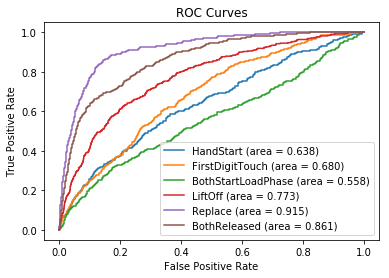

Test subject 10, class HandStart
Test subject 10, class FirstDigitTouch
Test subject 10, class BothStartLoadPhase
Test subject 10, class LiftOff
Test subject 10, class Replace
Test subject 10, class BothReleased
HandStart AUC score = 0.594
FirstDigitTouch AUC score = 0.856
BothStartLoadPhase AUC score = 0.734
LiftOff AUC score = 0.825
Replace AUC score = 0.901
BothReleased AUC score = 0.867


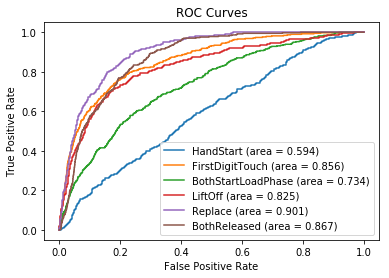

Test subject 11, class HandStart
Test subject 11, class FirstDigitTouch
Test subject 11, class BothStartLoadPhase
Test subject 11, class LiftOff
Test subject 11, class Replace
Test subject 11, class BothReleased
HandStart AUC score = 0.574
FirstDigitTouch AUC score = 0.677
BothStartLoadPhase AUC score = 0.677
LiftOff AUC score = 0.724
Replace AUC score = 0.824
BothReleased AUC score = 0.816


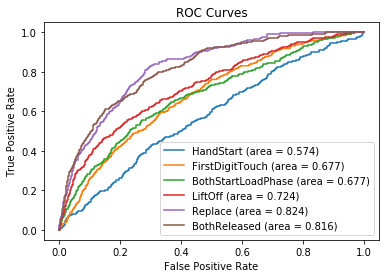

Test subject 12, class HandStart
Test subject 12, class FirstDigitTouch
Test subject 12, class BothStartLoadPhase
Test subject 12, class LiftOff
Test subject 12, class Replace
Test subject 12, class BothReleased
HandStart AUC score = 0.589
FirstDigitTouch AUC score = 0.650
BothStartLoadPhase AUC score = 0.621
LiftOff AUC score = 0.689
Replace AUC score = 0.755
BothReleased AUC score = 0.757


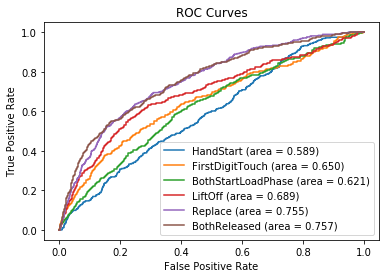

In [20]:


for subject in TEST_SUBJECTS:
    prediction_total = []
    test_data_total = []
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)

    x_test, _, y_test, _  = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.001)

    
    for i in range(N_LABELS):

        test_labels = to_categorical(y_test[:,i], num_classes = None)
                
        print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
        predictions = predict_on_sub(x_test, models[i], SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)